In [1]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tf
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1,2'

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/SHREC/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=3,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))   #32,231
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) #32,22,3
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters) #32,22,3,231,16
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters) #32,22,3,231,14,64

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 231)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 22, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1740160     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

## load data

In [8]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [9]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1  

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  #(1960,32,231) ndarray
X_1 = np.stack(X_1)  #(1960,32,22,3)
Y = np.stack(Y)

  1%|▍                                        | 19/1960 [00:00<00:21, 91.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 31/1960 [00:00<00:19, 101.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 57/1960 [00:00<00:16, 112.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 82/1960 [00:00<00:16, 116.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|██                                     | 106/1960 [00:00<00:15, 116.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▌                                    | 130/1960 [00:01<00:15, 116.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███                                    | 154/1960 [00:01<00:15, 118.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▌                                   | 179/1960 [00:01<00:14, 119.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|████                                   | 205/1960 [00:01<00:15, 114.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▌                                  | 228/1960 [00:02<00:16, 102.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|████▉                                  | 250/1960 [00:02<00:16, 102.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▍                                 | 272/1960 [00:02<00:16, 101.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▊                                 | 295/1960 [00:02<00:15, 106.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▏                                | 308/1960 [00:02<00:14, 110.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|██████▉                                | 346/1960 [00:03<00:13, 118.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▍                               | 371/1960 [00:03<00:13, 120.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▋                               | 384/1960 [00:03<00:13, 120.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▏                              | 410/1960 [00:03<00:12, 120.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▋                              | 436/1960 [00:03<00:12, 120.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▏                             | 462/1960 [00:04<00:12, 124.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▋                             | 488/1960 [00:04<00:11, 123.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████▏                            | 513/1960 [00:04<00:12, 116.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▋                            | 537/1960 [00:04<00:13, 108.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████                            | 559/1960 [00:04<00:13, 102.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▎                           | 571/1960 [00:05<00:13, 105.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|████████████                            | 593/1960 [00:05<00:13, 99.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████▏                          | 615/1960 [00:05<00:13, 102.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▋                          | 639/1960 [00:05<00:12, 104.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▏                         | 663/1960 [00:05<00:11, 109.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▋                         | 687/1960 [00:06<00:11, 110.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████▏                        | 712/1960 [00:06<00:10, 116.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▋                        | 736/1960 [00:06<00:10, 114.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████                        | 760/1960 [00:06<00:10, 114.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▌                       | 785/1960 [00:07<00:09, 118.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████                       | 809/1960 [00:07<00:09, 116.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▌                      | 833/1960 [00:07<00:09, 115.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████                      | 858/1960 [00:07<00:09, 118.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▌                     | 882/1960 [00:07<00:09, 118.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|██████████████████                     | 906/1960 [00:08<00:09, 116.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▌                    | 932/1960 [00:08<00:08, 120.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▊                    | 945/1960 [00:08<00:08, 119.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▎                   | 969/1960 [00:08<00:08, 116.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▊                   | 994/1960 [00:08<00:08, 119.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▋                  | 1018/1960 [00:08<00:07, 118.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▏                 | 1042/1960 [00:09<00:08, 114.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▋                 | 1067/1960 [00:09<00:07, 116.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▏                | 1091/1960 [00:09<00:07, 116.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▌                | 1115/1960 [00:09<00:07, 114.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|██████████████████████                | 1140/1960 [00:10<00:06, 118.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▌               | 1165/1960 [00:10<00:06, 119.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████               | 1190/1960 [00:10<00:06, 118.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▌              | 1216/1960 [00:10<00:06, 121.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|████████████████████████              | 1241/1960 [00:10<00:06, 118.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▌             | 1266/1960 [00:11<00:05, 118.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████             | 1290/1960 [00:11<00:05, 118.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▍            | 1314/1960 [00:11<00:05, 116.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▉            | 1339/1960 [00:11<00:05, 118.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▍           | 1363/1960 [00:11<00:05, 118.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▉           | 1387/1960 [00:12<00:04, 116.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▍          | 1412/1960 [00:12<00:04, 118.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▊          | 1436/1960 [00:12<00:04, 111.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████▎         | 1460/1960 [00:12<00:04, 111.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▊         | 1484/1960 [00:12<00:04, 112.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|█████████████████████████████         | 1496/1960 [00:13<00:04, 109.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▍        | 1519/1960 [00:13<00:04, 107.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1543/1960 [00:13<00:03, 110.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▎       | 1566/1960 [00:13<00:03, 108.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▊       | 1588/1960 [00:13<00:03, 107.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▎      | 1612/1960 [00:14<00:03, 110.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▋      | 1636/1960 [00:14<00:02, 109.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▏     | 1658/1960 [00:14<00:02, 108.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▌     | 1682/1960 [00:14<00:02, 111.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████     | 1706/1960 [00:15<00:02, 110.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▌    | 1730/1960 [00:15<00:02, 111.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|██████████████████████████████████    | 1754/1960 [00:15<00:01, 113.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▍   | 1778/1960 [00:15<00:01, 113.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|██████████████████████████████████▉   | 1802/1960 [00:15<00:01, 113.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▍  | 1827/1960 [00:16<00:01, 116.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▉  | 1851/1960 [00:16<00:00, 115.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▎ | 1875/1960 [00:16<00:00, 115.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▊ | 1899/1960 [00:16<00:00, 115.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████▎| 1923/1960 [00:16<00:00, 115.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▋| 1947/1960 [00:17<00:00, 113.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 113.65it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


In [10]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 840/840 [00:07<00:00, 118.52it/s]


In [11]:
# it may takes several times to reach the reported performance

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y, 
            batch_size=len(Y),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 8s 4ms/step - loss: 3.3539 - accuracy: 0.0643 - val_loss: 2.6389 - val_accuracy: 0.1048
Epoch 2/600
1960/1960 [==============================] - 0s 150us/step - loss: 2.9080 - accuracy: 0.1255 - val_loss: 2.6397 - val_accuracy: 0.0607
Epoch 3/600
1960/1960 [==============================] - 0s 156us/step - loss: 2.6572 - accuracy: 0.1821 - val_loss: 2.6407 - val_accuracy: 0.0607
Epoch 4/600
1960/1960 [==============================] - 0s 137us/step - loss: 2.3952 - accuracy: 0.2296 - val_loss: 2.6421 - val_accuracy: 0.0607
Epoch 5/600
1960/1960 [==============================] - 0s 139us/step - loss: 2.2214 - accuracy: 0.2811 - val_loss: 2.6439 - val_accuracy: 0.0607
Epoch 6/600
1960/1960 [==============================] - 0s 133us/step - loss: 2.0115 - accuracy: 0.3622 - val_loss: 2.6462 - val_accuracy: 0.0607
Epoch 7/600
1960/1960 [==============================] - 0s 136us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 166us/step - loss: 0.1349 - accuracy: 0.9816 - val_loss: 4.0150 - val_accuracy: 0.0607
Epoch 58/600
1960/1960 [==============================] - 0s 153us/step - loss: 0.1425 - accuracy: 0.9755 - val_loss: 4.0149 - val_accuracy: 0.0607
Epoch 59/600
1960/1960 [==============================] - 0s 155us/step - loss: 0.1273 - accuracy: 0.9806 - val_loss: 4.0104 - val_accuracy: 0.0607
Epoch 60/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.1312 - accuracy: 0.9786 - val_loss: 4.0085 - val_accuracy: 0.0607
Epoch 61/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.1259 - accuracy: 0.9806 - val_loss: 4.0181 - val_accuracy: 0.0607
Epoch 62/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.1242 - accuracy: 0.9811 - val_loss: 4.0422 - val_accuracy: 0.0607
Epoch 63/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.1161 - accuracy: 0.9821 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0451 - accuracy: 0.9944 - val_loss: 4.1626 - val_accuracy: 0.0607
Epoch 114/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0542 - accuracy: 0.9929 - val_loss: 4.1913 - val_accuracy: 0.0607
Epoch 115/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0403 - accuracy: 0.9980 - val_loss: 4.2231 - val_accuracy: 0.0607
Epoch 116/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0403 - accuracy: 0.9959 - val_loss: 4.2579 - val_accuracy: 0.0607
Epoch 117/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0462 - accuracy: 0.9944 - val_loss: 4.2811 - val_accuracy: 0.0607
Epoch 118/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0451 - accuracy: 0.9969 - val_loss: 4.3030 - val_accuracy: 0.0607
Epoch 119/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0454 - accuracy: 0.9959

Epoch 168/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0443 - accuracy: 0.9959 - val_loss: 4.1736 - val_accuracy: 0.0679
Epoch 169/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0409 - accuracy: 0.9964 - val_loss: 4.1655 - val_accuracy: 0.0679
Epoch 170/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0399 - accuracy: 0.9969 - val_loss: 4.1573 - val_accuracy: 0.0690
Epoch 171/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0386 - accuracy: 0.9974 - val_loss: 4.1492 - val_accuracy: 0.0690
Epoch 172/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0410 - accuracy: 0.9949 - val_loss: 4.1412 - val_accuracy: 0.0690
Epoch 173/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0413 - accuracy: 0.9959 - val_loss: 4.1327 - val_accuracy: 0.0690
Epoch 174/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0381 - accuracy: 0.9974

Epoch 223/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0388 - accuracy: 0.9969 - val_loss: 3.5948 - val_accuracy: 0.1083
Epoch 224/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0434 - accuracy: 0.9964 - val_loss: 3.5817 - val_accuracy: 0.1083
Epoch 225/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0380 - accuracy: 0.9974 - val_loss: 3.5684 - val_accuracy: 0.1107
Epoch 226/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0404 - accuracy: 0.9959 - val_loss: 3.5544 - val_accuracy: 0.1131
Epoch 227/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0399 - accuracy: 0.9959 - val_loss: 3.5415 - val_accuracy: 0.1167
Epoch 228/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0414 - accuracy: 0.9964 - val_loss: 3.5277 - val_accuracy: 0.1202
Epoch 229/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0392 - accuracy: 0.9959

Epoch 278/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0392 - accuracy: 0.9959 - val_loss: 2.8046 - val_accuracy: 0.2750
Epoch 279/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0421 - accuracy: 0.9974 - val_loss: 2.7902 - val_accuracy: 0.2786
Epoch 280/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0394 - accuracy: 0.9954 - val_loss: 2.7747 - val_accuracy: 0.2821
Epoch 281/600
1960/1960 [==============================] - 0s 149us/step - loss: 0.0380 - accuracy: 0.9974 - val_loss: 2.7601 - val_accuracy: 0.2833
Epoch 282/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0373 - accuracy: 0.9969 - val_loss: 2.7446 - val_accuracy: 0.2905
Epoch 283/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0404 - accuracy: 0.9954 - val_loss: 2.7295 - val_accuracy: 0.2940
Epoch 284/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0403 - accuracy: 0.9974

Epoch 333/600
1960/1960 [==============================] - 0s 157us/step - loss: 0.0392 - accuracy: 0.9969 - val_loss: 1.9839 - val_accuracy: 0.4655
Epoch 334/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0401 - accuracy: 0.9954 - val_loss: 1.9696 - val_accuracy: 0.4690
Epoch 335/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0417 - accuracy: 0.9954 - val_loss: 1.9549 - val_accuracy: 0.4714
Epoch 336/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0412 - accuracy: 0.9980 - val_loss: 1.9402 - val_accuracy: 0.4738
Epoch 337/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0396 - accuracy: 0.9959 - val_loss: 1.9257 - val_accuracy: 0.4762
Epoch 338/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0393 - accuracy: 0.9974 - val_loss: 1.9117 - val_accuracy: 0.4786
Epoch 339/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0384 - accuracy: 0.9974

Epoch 388/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0340 - accuracy: 0.9985 - val_loss: 1.2641 - val_accuracy: 0.6643
Epoch 389/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0372 - accuracy: 0.9974 - val_loss: 1.2526 - val_accuracy: 0.6679
Epoch 390/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0381 - accuracy: 0.9964 - val_loss: 1.2419 - val_accuracy: 0.6702
Epoch 391/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0384 - accuracy: 0.9959 - val_loss: 1.2309 - val_accuracy: 0.6738
Epoch 392/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0400 - accuracy: 0.9959 - val_loss: 1.2200 - val_accuracy: 0.6762
Epoch 393/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0385 - accuracy: 0.9954 - val_loss: 1.2096 - val_accuracy: 0.6774
Epoch 394/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0395 - accuracy: 0.9964

Epoch 443/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0373 - accuracy: 0.9969 - val_loss: 0.7550 - val_accuracy: 0.8107
Epoch 444/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0349 - accuracy: 0.9974 - val_loss: 0.7478 - val_accuracy: 0.8119
Epoch 445/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0378 - accuracy: 0.9985 - val_loss: 0.7406 - val_accuracy: 0.8143
Epoch 446/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0395 - accuracy: 0.9964 - val_loss: 0.7335 - val_accuracy: 0.8190
Epoch 447/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0351 - accuracy: 0.9985 - val_loss: 0.7264 - val_accuracy: 0.8190
Epoch 448/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0374 - accuracy: 0.9964 - val_loss: 0.7194 - val_accuracy: 0.8214
Epoch 449/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0438 - accuracy: 0.9954

Epoch 498/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0379 - accuracy: 0.9980 - val_loss: 0.4567 - val_accuracy: 0.8810
Epoch 499/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0371 - accuracy: 0.9985 - val_loss: 0.4526 - val_accuracy: 0.8810
Epoch 500/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0385 - accuracy: 0.9969 - val_loss: 0.4486 - val_accuracy: 0.8810
Epoch 501/600
1960/1960 [==============================] - 0s 153us/step - loss: 0.0390 - accuracy: 0.9959 - val_loss: 0.4446 - val_accuracy: 0.8810
Epoch 502/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0357 - accuracy: 0.9990 - val_loss: 0.4408 - val_accuracy: 0.8810
Epoch 503/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0403 - accuracy: 0.9944 - val_loss: 0.4371 - val_accuracy: 0.8810
Epoch 504/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0351 - accuracy: 0.9969

Epoch 553/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0366 - accuracy: 0.9974 - val_loss: 0.3046 - val_accuracy: 0.9202
Epoch 554/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0365 - accuracy: 0.9959 - val_loss: 0.3027 - val_accuracy: 0.9202
Epoch 555/600
1960/1960 [==============================] - 0s 147us/step - loss: 0.0384 - accuracy: 0.9954 - val_loss: 0.3007 - val_accuracy: 0.9202
Epoch 556/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0372 - accuracy: 0.9959 - val_loss: 0.2987 - val_accuracy: 0.9214
Epoch 557/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0375 - accuracy: 0.9985 - val_loss: 0.2968 - val_accuracy: 0.9226
Epoch 558/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0423 - accuracy: 0.9959 - val_loss: 0.2948 - val_accuracy: 0.9226
Epoch 559/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0345 - accuracy: 0.9980

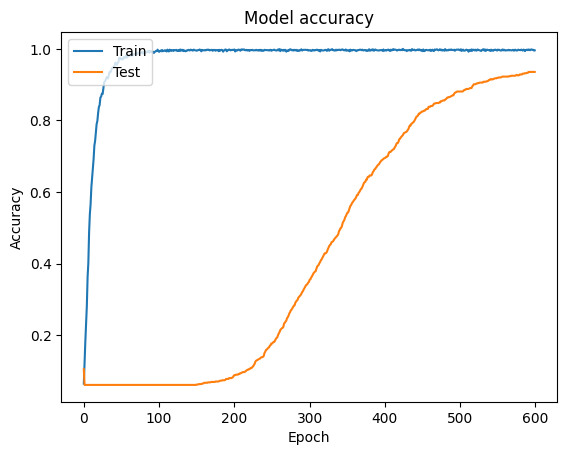

In [12]:
# Plot training & validation accuracy values
# plt.ylim(90,100)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/SHREC/images/DRLDDNet_14_test1.png")
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# DD_Net.save_weights('weights/coarse_heavy.h1')

In [14]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [15]:
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [16]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9357142857142857


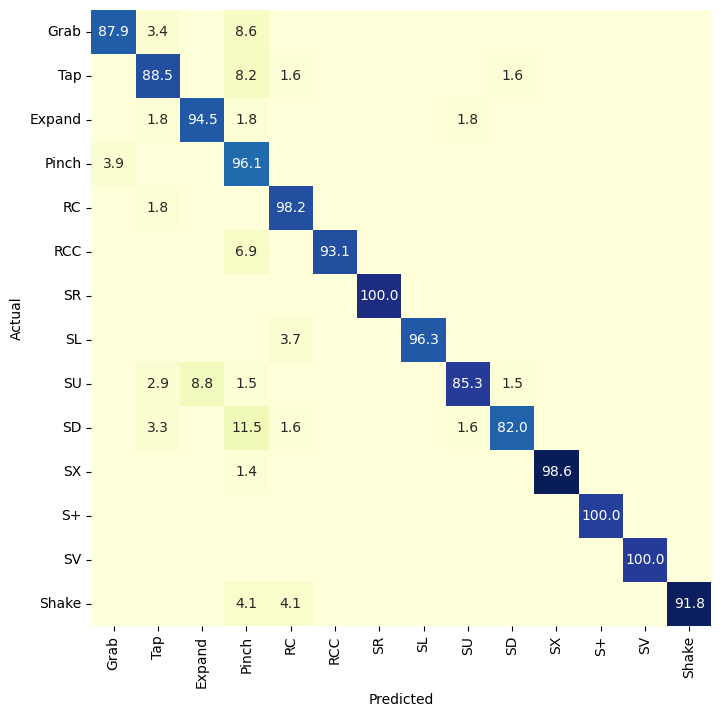

In [17]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_tes2.png', labels, ymap=None, figsize=(8,8))

## Training with frame_sampling

In [18]:
lr = 5e-6
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [19]:
epochs = 20  #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
        
       
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net_model = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


  1%|▏                                       | 12/1960 [00:00<00:17, 112.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:17, 111.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 59/1960 [00:00<00:17, 109.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 83/1960 [00:00<00:16, 111.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|██▏                                    | 107/1960 [00:00<00:16, 110.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▌                                    | 131/1960 [00:01<00:16, 113.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███                                    | 156/1960 [00:01<00:15, 116.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▌                                   | 181/1960 [00:01<00:14, 119.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████                                   | 207/1960 [00:01<00:14, 122.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▋                                  | 233/1960 [00:02<00:14, 122.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████▏                                 | 259/1960 [00:02<00:13, 123.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▋                                 | 285/1960 [00:02<00:13, 124.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▏                                | 311/1960 [00:02<00:13, 125.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▋                                | 337/1960 [00:02<00:12, 125.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▏                               | 363/1960 [00:03<00:12, 126.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▋                               | 389/1960 [00:03<00:12, 126.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▎                              | 416/1960 [00:03<00:12, 126.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|████████▊                              | 442/1960 [00:03<00:12, 126.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▎                             | 469/1960 [00:03<00:11, 126.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▊                             | 495/1960 [00:04<00:11, 126.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▎                            | 521/1960 [00:04<00:11, 126.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▉                            | 547/1960 [00:04<00:11, 126.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▍                           | 573/1960 [00:04<00:10, 126.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|███████████▉                           | 599/1960 [00:04<00:11, 121.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▍                          | 625/1960 [00:05<00:11, 120.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▋                          | 638/1960 [00:05<00:10, 120.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▍                         | 675/1960 [00:05<00:10, 117.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|█████████████▉                         | 699/1960 [00:05<00:10, 116.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▍                        | 723/1960 [00:05<00:10, 116.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▋                        | 735/1960 [00:06<00:10, 113.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████                        | 759/1960 [00:06<00:10, 110.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▌                       | 783/1960 [00:06<00:10, 112.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████                       | 807/1960 [00:06<00:10, 108.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▌                      | 830/1960 [00:06<00:10, 109.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|████████████████▉                      | 853/1960 [00:07<00:09, 111.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▍                     | 877/1960 [00:07<00:09, 111.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|█████████████████▉                     | 901/1960 [00:07<00:09, 110.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▍                    | 926/1960 [00:07<00:09, 114.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▉                    | 950/1960 [00:08<00:08, 113.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▍                   | 974/1960 [00:08<00:08, 111.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▊                   | 998/1960 [00:08<00:08, 113.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▊                  | 1022/1960 [00:08<00:08, 112.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▎                 | 1046/1960 [00:08<00:08, 113.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▋                 | 1070/1960 [00:09<00:07, 114.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▏                | 1094/1960 [00:09<00:07, 113.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▍                | 1106/1960 [00:09<00:07, 112.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|█████████████████████▉                | 1130/1960 [00:09<00:07, 112.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▎               | 1154/1960 [00:09<00:07, 111.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▊               | 1178/1960 [00:10<00:07, 110.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▎              | 1202/1960 [00:10<00:06, 113.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▊              | 1226/1960 [00:10<00:06, 113.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▏             | 1250/1960 [00:10<00:06, 113.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▋             | 1274/1960 [00:10<00:05, 115.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████▏            | 1298/1960 [00:11<00:05, 114.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▋            | 1322/1960 [00:11<00:05, 112.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████            | 1346/1960 [00:11<00:05, 115.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▌           | 1370/1960 [00:11<00:05, 113.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|███████████████████████████           | 1394/1960 [00:11<00:04, 113.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▍          | 1418/1960 [00:12<00:04, 115.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|███████████████████████████▉          | 1442/1960 [00:12<00:04, 109.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▍         | 1464/1960 [00:12<00:04, 108.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▊         | 1487/1960 [00:12<00:04, 108.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▎        | 1510/1960 [00:13<00:04, 108.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▋        | 1532/1960 [00:13<00:03, 107.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████▏       | 1556/1960 [00:13<00:03, 109.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▌       | 1578/1960 [00:13<00:03, 108.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1601/1960 [00:13<00:03, 109.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1625/1960 [00:14<00:03, 109.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▉      | 1648/1960 [00:14<00:02, 109.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▍     | 1671/1960 [00:14<00:02, 110.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▊     | 1695/1960 [00:14<00:02, 112.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▎    | 1719/1960 [00:14<00:02, 111.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▊    | 1743/1960 [00:15<00:01, 112.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▎   | 1767/1960 [00:15<00:01, 113.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▋   | 1791/1960 [00:15<00:01, 112.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▏  | 1815/1960 [00:15<00:01, 113.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▋  | 1839/1960 [00:15<00:01, 113.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1863/1960 [00:16<00:00, 114.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1887/1960 [00:16<00:00, 114.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▊ | 1899/1960 [00:16<00:00, 113.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▌| 1935/1960 [00:16<00:00, 114.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▋| 1947/1960 [00:16<00:00, 113.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 114.90it/s]


(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0402 - accuracy: 0.9964 - val_loss: 0.2338 - val_accuracy: 0.9357
epoch1


  1%|▏                                       | 12/1960 [00:00<00:17, 110.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:16, 114.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 61/1960 [00:00<00:16, 118.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▌                                      | 74/1960 [00:00<00:15, 120.89it/s]

(32, 22, 3)
(32, 22, 3)


  4%|█▊                                      | 87/1960 [00:00<00:15, 121.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▏                                    | 113/1960 [00:00<00:15, 122.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▊                                    | 139/1960 [00:01<00:14, 123.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▎                                   | 166/1960 [00:01<00:14, 125.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▊                                   | 192/1960 [00:01<00:14, 125.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▎                                  | 218/1960 [00:01<00:13, 126.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▉                                  | 245/1960 [00:01<00:13, 128.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▍                                 | 272/1960 [00:02<00:13, 129.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▉                                 | 299/1960 [00:02<00:12, 130.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▌                                | 327/1960 [00:02<00:12, 131.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|███████                                | 354/1960 [00:02<00:12, 128.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▌                               | 380/1960 [00:03<00:12, 127.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████                               | 406/1960 [00:03<00:12, 126.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▌                              | 432/1960 [00:03<00:12, 126.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 458/1960 [00:03<00:11, 126.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▋                             | 484/1960 [00:03<00:11, 123.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████▏                            | 510/1960 [00:04<00:11, 122.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▋                            | 536/1960 [00:04<00:11, 122.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▏                           | 562/1960 [00:04<00:11, 123.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▋                           | 588/1960 [00:04<00:11, 120.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|███████████▉                           | 601/1960 [00:04<00:11, 117.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████▏                          | 613/1960 [00:04<00:11, 116.03it/s]

(32, 22, 3)
(32, 22, 3)


 32%|████████████▍                          | 625/1960 [00:05<00:11, 115.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▋                          | 638/1960 [00:05<00:11, 117.01it/s]

(32, 22, 3)


 33%|████████████▉                          | 650/1960 [00:05<00:11, 115.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▏                         | 662/1960 [00:05<00:11, 114.87it/s]

(32, 22, 3)


 34%|█████████████▍                         | 674/1960 [00:05<00:11, 114.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▋                         | 686/1960 [00:05<00:11, 114.41it/s]

(32, 22, 3)


 36%|█████████████▉                         | 698/1960 [00:05<00:10, 115.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████▏                        | 711/1960 [00:05<00:10, 118.29it/s]

(32, 22, 3)


 37%|██████████████▍                        | 724/1960 [00:05<00:10, 118.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▉                        | 748/1960 [00:06<00:10, 116.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▍                       | 773/1960 [00:06<00:09, 118.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|███████████████▉                       | 798/1960 [00:06<00:09, 119.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▎                      | 822/1960 [00:06<00:09, 119.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▊                      | 847/1960 [00:06<00:09, 120.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▎                     | 873/1960 [00:07<00:08, 121.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|█████████████████▉                     | 899/1960 [00:07<00:08, 120.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▍                    | 925/1960 [00:07<00:08, 123.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|██████████████████▉                    | 951/1960 [00:07<00:08, 122.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▍                   | 977/1960 [00:07<00:08, 122.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▍                  | 1003/1960 [00:08<00:07, 122.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▉                  | 1028/1960 [00:08<00:07, 119.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▍                 | 1052/1960 [00:08<00:07, 117.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▉                 | 1077/1960 [00:08<00:07, 119.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▎                | 1101/1960 [00:09<00:07, 116.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▊                | 1125/1960 [00:09<00:07, 115.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▎               | 1149/1960 [00:09<00:06, 116.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▋               | 1173/1960 [00:09<00:06, 115.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▏              | 1197/1960 [00:09<00:06, 115.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▋              | 1221/1960 [00:10<00:06, 116.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▏             | 1245/1960 [00:10<00:06, 115.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▌             | 1269/1960 [00:10<00:06, 104.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████             | 1291/1960 [00:10<00:06, 100.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████▉             | 1302/1960 [00:10<00:06, 97.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▋            | 1326/1960 [00:11<00:05, 107.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▏           | 1352/1960 [00:11<00:05, 114.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▋           | 1376/1960 [00:11<00:05, 116.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|███████████████████████████▏          | 1401/1960 [00:11<00:04, 118.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▋          | 1426/1960 [00:11<00:04, 116.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████          | 1450/1960 [00:12<00:04, 114.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▌         | 1474/1960 [00:12<00:04, 114.55it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|█████████████████████████████         | 1498/1960 [00:12<00:04, 112.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▌        | 1522/1960 [00:12<00:03, 111.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1546/1960 [00:13<00:03, 113.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▍       | 1570/1960 [00:13<00:03, 110.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▉       | 1594/1960 [00:13<00:03, 110.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▎      | 1618/1960 [00:13<00:03, 113.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▊      | 1642/1960 [00:13<00:02, 113.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▎     | 1666/1960 [00:14<00:02, 114.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▊     | 1691/1960 [00:14<00:02, 118.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▎    | 1715/1960 [00:14<00:02, 117.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▋    | 1739/1960 [00:14<00:01, 117.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▏   | 1764/1960 [00:14<00:01, 120.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▋   | 1789/1960 [00:15<00:01, 118.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████▏  | 1813/1960 [00:15<00:01, 117.46it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▋  | 1839/1960 [00:15<00:01, 119.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████▏ | 1864/1960 [00:15<00:00, 119.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1888/1960 [00:15<00:00, 119.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████ | 1912/1960 [00:16<00:00, 117.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▌| 1936/1960 [00:16<00:00, 117.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 137us/step - loss: 0.0440 - accuracy: 0.9944 - val_loss: 0.2330 - val_accuracy: 0.9357
epoch2


  1%|▏                                       | 12/1960 [00:00<00:17, 111.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:16, 113.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 60/1960 [00:00<00:17, 107.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)

  4%|█▋                                      | 82/1960 [00:00<00:18, 100.44it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|██                                     | 105/1960 [00:00<00:17, 105.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▌                                    | 130/1960 [00:01<00:16, 111.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███                                    | 155/1960 [00:01<00:15, 116.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▌                                   | 179/1960 [00:01<00:15, 117.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|████                                   | 204/1960 [00:01<00:14, 119.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▌                                  | 229/1960 [00:02<00:14, 120.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████                                  | 255/1960 [00:02<00:14, 120.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▌                                 | 281/1960 [00:02<00:13, 121.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████                                 | 307/1960 [00:02<00:13, 123.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▋                                | 333/1960 [00:02<00:13, 124.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|███████▏                               | 359/1960 [00:03<00:12, 124.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▋                               | 385/1960 [00:03<00:12, 125.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▏                              | 411/1960 [00:03<00:12, 125.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▋                              | 437/1960 [00:03<00:12, 124.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▏                             | 463/1960 [00:03<00:11, 125.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▋                             | 489/1960 [00:04<00:11, 124.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████▏                            | 515/1960 [00:04<00:11, 125.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▊                            | 542/1960 [00:04<00:11, 126.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▎                           | 569/1960 [00:04<00:10, 128.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▊                           | 595/1960 [00:04<00:11, 123.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████                           | 608/1960 [00:05<00:11, 121.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▊                          | 647/1960 [00:05<00:10, 122.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▏                         | 660/1960 [00:05<00:10, 119.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▌                         | 684/1960 [00:05<00:10, 118.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████                         | 709/1960 [00:05<00:10, 121.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▋                        | 735/1960 [00:06<00:10, 119.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████                        | 760/1960 [00:06<00:10, 119.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▋                       | 786/1960 [00:06<00:09, 121.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████▏                      | 811/1960 [00:06<00:09, 118.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▌                      | 835/1960 [00:06<00:09, 116.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▏                     | 861/1960 [00:07<00:09, 120.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▋                     | 887/1960 [00:07<00:08, 120.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▏                    | 913/1960 [00:07<00:08, 121.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▋                    | 939/1960 [00:07<00:08, 122.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▏                   | 965/1960 [00:08<00:08, 122.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▋                   | 991/1960 [00:08<00:07, 124.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▋                  | 1017/1960 [00:08<00:07, 124.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▏                 | 1043/1960 [00:08<00:07, 121.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▋                 | 1069/1960 [00:08<00:07, 121.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▉                 | 1082/1960 [00:08<00:07, 121.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▍                | 1108/1960 [00:09<00:07, 121.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|█████████████████████▉                | 1134/1960 [00:09<00:06, 122.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▍               | 1160/1960 [00:09<00:06, 122.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|██████████████████████▉               | 1186/1960 [00:09<00:06, 121.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▍              | 1212/1960 [00:10<00:06, 122.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▉              | 1237/1960 [00:10<00:06, 118.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▍             | 1261/1960 [00:10<00:05, 117.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|████████████████████████▉             | 1285/1960 [00:10<00:05, 115.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▍            | 1309/1960 [00:10<00:05, 112.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▊            | 1334/1960 [00:11<00:05, 114.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▎           | 1359/1960 [00:11<00:05, 116.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▊           | 1383/1960 [00:11<00:05, 115.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▎          | 1408/1960 [00:11<00:04, 117.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▊          | 1432/1960 [00:11<00:04, 115.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████▏         | 1456/1960 [00:12<00:04, 114.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▋         | 1481/1960 [00:12<00:04, 117.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▏        | 1505/1960 [00:12<00:03, 115.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▋        | 1530/1960 [00:12<00:03, 117.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████▏       | 1555/1960 [00:13<00:03, 119.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▌       | 1579/1960 [00:13<00:03, 116.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1604/1960 [00:13<00:03, 118.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1629/1960 [00:13<00:02, 118.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|████████████████████████████████      | 1653/1960 [00:13<00:02, 116.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▌     | 1678/1960 [00:14<00:02, 119.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████     | 1704/1960 [00:14<00:02, 119.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▌    | 1729/1960 [00:14<00:01, 119.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████    | 1755/1960 [00:14<00:01, 122.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▌   | 1781/1960 [00:14<00:01, 121.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████   | 1807/1960 [00:15<00:01, 119.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▎  | 1819/1960 [00:15<00:01, 119.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▋  | 1843/1960 [00:15<00:01, 105.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████▏ | 1866/1960 [00:15<00:00, 107.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▋ | 1891/1960 [00:15<00:00, 113.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████▏| 1916/1960 [00:16<00:00, 116.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▌| 1940/1960 [00:16<00:00, 116.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.67it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 140us/step - loss: 0.0479 - accuracy: 0.9929 - val_loss: 0.2319 - val_accuracy: 0.9357
epoch3


  1%|▏                                       | 12/1960 [00:00<00:17, 112.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:16, 113.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 60/1960 [00:00<00:16, 115.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 85/1960 [00:00<00:16, 116.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▏                                    | 109/1960 [00:00<00:15, 115.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▋                                    | 133/1960 [00:01<00:15, 116.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▏                                   | 158/1960 [00:01<00:15, 118.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▋                                   | 184/1960 [00:01<00:14, 120.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▏                                  | 210/1960 [00:01<00:14, 122.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▋                                  | 236/1960 [00:01<00:14, 122.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████▏                                 | 262/1960 [00:02<00:13, 122.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▋                                 | 288/1960 [00:02<00:13, 121.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▏                                | 314/1960 [00:02<00:13, 124.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▊                                | 340/1960 [00:02<00:13, 124.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▎                               | 366/1960 [00:03<00:12, 124.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▊                               | 392/1960 [00:03<00:12, 125.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▎                              | 418/1960 [00:03<00:12, 124.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|████████▊                              | 444/1960 [00:03<00:12, 124.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▎                             | 470/1960 [00:03<00:11, 126.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▊                             | 496/1960 [00:04<00:11, 124.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▍                            | 522/1960 [00:04<00:11, 125.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▉                            | 548/1960 [00:04<00:11, 126.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▍                           | 575/1960 [00:04<00:10, 128.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|███████████▉                           | 601/1960 [00:04<00:10, 124.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▍                          | 627/1960 [00:05<00:10, 122.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▉                          | 653/1960 [00:05<00:10, 123.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▌                         | 679/1960 [00:05<00:10, 122.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▊                         | 692/1960 [00:05<00:10, 120.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▎                        | 719/1960 [00:05<00:09, 124.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▊                        | 745/1960 [00:06<00:10, 120.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▎                       | 771/1960 [00:06<00:09, 120.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|███████████████▊                       | 797/1960 [00:06<00:09, 122.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▍                      | 823/1960 [00:06<00:09, 118.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▊                      | 848/1960 [00:06<00:09, 118.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▍                     | 874/1960 [00:07<00:09, 118.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|█████████████████▊                     | 898/1960 [00:07<00:09, 116.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▎                    | 923/1960 [00:07<00:08, 119.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▊                    | 947/1960 [00:07<00:08, 119.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▎                   | 971/1960 [00:08<00:08, 118.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▊                   | 997/1960 [00:08<00:07, 121.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▊                  | 1022/1960 [00:08<00:07, 119.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▎                 | 1046/1960 [00:08<00:07, 118.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▊                 | 1072/1960 [00:08<00:07, 121.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▎                | 1098/1960 [00:09<00:07, 119.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▊                | 1123/1960 [00:09<00:06, 120.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|██████████████████████                | 1136/1960 [00:09<00:06, 121.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▌               | 1161/1960 [00:09<00:06, 118.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▉               | 1185/1960 [00:09<00:06, 116.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▍              | 1210/1960 [00:10<00:06, 117.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▉              | 1234/1960 [00:10<00:06, 117.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▍             | 1258/1960 [00:10<00:05, 117.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|████████████████████████▉             | 1284/1960 [00:10<00:05, 119.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▎            | 1308/1960 [00:10<00:05, 115.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▊            | 1332/1960 [00:11<00:05, 115.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▌           | 1368/1960 [00:11<00:05, 116.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▉           | 1392/1960 [00:11<00:04, 115.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▍          | 1417/1960 [00:11<00:04, 118.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▋          | 1429/1960 [00:11<00:04, 113.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████▏         | 1453/1960 [00:12<00:04, 112.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▋         | 1477/1960 [00:12<00:04, 113.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████         | 1501/1960 [00:12<00:04, 111.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▌        | 1525/1960 [00:12<00:03, 110.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████        | 1549/1960 [00:12<00:03, 113.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▍       | 1573/1960 [00:13<00:03, 111.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▉       | 1597/1960 [00:13<00:03, 112.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▍      | 1621/1960 [00:13<00:02, 114.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▉      | 1645/1960 [00:13<00:02, 112.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▍     | 1670/1960 [00:14<00:02, 115.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|████████████████████████████████▉     | 1696/1960 [00:14<00:02, 118.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▎    | 1720/1960 [00:14<00:02, 117.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▊    | 1745/1960 [00:14<00:01, 119.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▎   | 1771/1960 [00:14<00:01, 121.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|██████████████████████████████████▊   | 1797/1960 [00:15<00:01, 120.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▎  | 1823/1960 [00:15<00:01, 120.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▌  | 1836/1960 [00:15<00:01, 121.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1861/1960 [00:15<00:00, 118.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1885/1960 [00:15<00:00, 118.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|█████████████████████████████████████ | 1909/1960 [00:16<00:00, 117.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▍| 1934/1960 [00:16<00:00, 118.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1


1960/1960 [==============================] - 0s 136us/step - loss: 0.0462 - accuracy: 0.9954 - val_loss: 0.2310 - val_accuracy: 0.9357
epoch4


  1%|▏                                       | 12/1960 [00:00<00:17, 111.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:17, 112.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 60/1960 [00:00<00:16, 115.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 85/1960 [00:00<00:15, 118.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▏                                    | 109/1960 [00:00<00:15, 116.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▋                                    | 133/1960 [00:01<00:15, 116.55it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███                                    | 157/1960 [00:01<00:15, 117.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▌                                   | 181/1960 [00:01<00:15, 116.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████                                   | 207/1960 [00:01<00:14, 119.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▌                                  | 231/1960 [00:01<00:14, 118.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████                                  | 255/1960 [00:02<00:14, 116.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▌                                 | 280/1960 [00:02<00:14, 118.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████                                 | 305/1960 [00:02<00:13, 118.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▌                                | 330/1960 [00:02<00:13, 118.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|███████                                | 355/1960 [00:03<00:13, 118.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▌                               | 380/1960 [00:03<00:13, 119.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████                               | 405/1960 [00:03<00:12, 120.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▌                              | 430/1960 [00:03<00:12, 118.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 455/1960 [00:03<00:12, 119.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▌                             | 480/1960 [00:04<00:12, 119.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████                             | 505/1960 [00:04<00:12, 120.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▌                            | 531/1960 [00:04<00:11, 121.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|███████████                            | 557/1960 [00:04<00:11, 123.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▌                           | 583/1960 [00:04<00:11, 121.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████                           | 608/1960 [00:05<00:11, 119.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▌                          | 633/1960 [00:05<00:11, 119.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████                          | 658/1960 [00:05<00:10, 118.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▌                         | 682/1960 [00:05<00:11, 115.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████                         | 707/1960 [00:05<00:10, 116.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▎                        | 720/1960 [00:06<00:10, 118.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▌                        | 732/1960 [00:06<00:10, 115.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▊                        | 744/1960 [00:06<00:10, 115.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████                        | 756/1960 [00:06<00:10, 114.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▎                       | 768/1960 [00:06<00:10, 115.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▌                       | 781/1960 [00:06<00:10, 117.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▊                       | 793/1960 [00:06<00:09, 117.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████                       | 805/1960 [00:06<00:09, 116.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▎                      | 817/1960 [00:06<00:09, 115.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▍                      | 829/1960 [00:07<00:09, 113.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▋                      | 841/1960 [00:07<00:09, 113.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|████████████████▉                      | 854/1960 [00:07<00:09, 115.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▏                     | 866/1960 [00:07<00:09, 116.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▍                     | 878/1960 [00:07<00:09, 114.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▋                     | 890/1960 [00:07<00:09, 114.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▏                    | 915/1960 [00:07<00:09, 115.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▋                    | 939/1960 [00:07<00:08, 116.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▏                   | 963/1960 [00:08<00:08, 116.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▋                   | 988/1960 [00:08<00:08, 118.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▌                  | 1012/1960 [00:08<00:08, 117.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████                  | 1036/1960 [00:08<00:07, 115.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▌                 | 1060/1960 [00:09<00:07, 114.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|█████████████████████                 | 1084/1960 [00:09<00:07, 114.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▍                | 1108/1960 [00:09<00:07, 115.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▋                | 1120/1960 [00:09<00:07, 115.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|█████████████████████▉                | 1132/1960 [00:09<00:07, 116.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|██████████████████████▏               | 1145/1960 [00:09<00:06, 117.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▍               | 1157/1960 [00:09<00:06, 116.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▋               | 1169/1960 [00:09<00:06, 116.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▉               | 1181/1960 [00:10<00:06, 115.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▏              | 1193/1960 [00:10<00:06, 115.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▍              | 1206/1960 [00:10<00:06, 117.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▌              | 1218/1960 [00:10<00:06, 117.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▊              | 1230/1960 [00:10<00:06, 116.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|████████████████████████              | 1242/1960 [00:10<00:06, 115.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▎             | 1254/1960 [00:10<00:06, 115.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▊             | 1279/1960 [00:10<00:05, 118.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████             | 1291/1960 [00:11<00:05, 116.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████▎            | 1303/1960 [00:11<00:05, 116.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▋            | 1327/1960 [00:11<00:05, 116.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▉            | 1340/1960 [00:11<00:05, 117.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▏           | 1352/1960 [00:11<00:05, 118.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▍           | 1364/1960 [00:11<00:05, 117.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▋           | 1376/1960 [00:11<00:04, 117.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▉           | 1388/1960 [00:11<00:04, 116.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|███████████████████████████▏          | 1400/1960 [00:11<00:04, 117.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▍          | 1413/1960 [00:12<00:04, 118.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▋          | 1425/1960 [00:12<00:04, 116.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████          | 1449/1960 [00:12<00:04, 112.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▌         | 1473/1960 [00:12<00:04, 112.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|█████████████████████████████         | 1497/1960 [00:12<00:04, 111.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▍        | 1521/1960 [00:13<00:03, 111.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1545/1960 [00:13<00:03, 113.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████▏       | 1557/1960 [00:13<00:03, 110.55it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▍       | 1569/1960 [00:13<00:03, 109.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▋       | 1580/1960 [00:13<00:03, 108.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▊       | 1591/1960 [00:13<00:03, 108.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1603/1960 [00:13<00:03, 109.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▎      | 1615/1960 [00:13<00:03, 109.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1626/1960 [00:13<00:03, 109.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▋      | 1637/1960 [00:14<00:02, 108.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▉      | 1648/1960 [00:14<00:02, 108.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▏     | 1659/1960 [00:14<00:02, 108.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▍     | 1671/1960 [00:14<00:02, 109.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▋     | 1683/1960 [00:14<00:02, 111.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▊     | 1695/1960 [00:14<00:02, 112.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████     | 1707/1960 [00:14<00:02, 106.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▎    | 1719/1960 [00:14<00:02, 107.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▊    | 1743/1960 [00:15<00:01, 110.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▎   | 1767/1960 [00:15<00:01, 113.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▋   | 1791/1960 [00:15<00:01, 113.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▏  | 1815/1960 [00:15<00:01, 112.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▋  | 1839/1960 [00:15<00:01, 113.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1863/1960 [00:16<00:00, 114.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1887/1960 [00:16<00:00, 115.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████ | 1911/1960 [00:16<00:00, 115.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▌| 1935/1960 [00:16<00:00, 115.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 115.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 142us/step - loss: 0.0489 - accuracy: 0.9939 - val_loss: 0.2298 - val_accuracy: 0.9369
epoch5


  1%|▏                                       | 11/1960 [00:00<00:17, 108.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  1%|▍                                       | 23/1960 [00:00<00:17, 110.05it/s]

(32, 22, 3)


  2%|▋                                       | 35/1960 [00:00<00:17, 111.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▉                                       | 47/1960 [00:00<00:16, 112.71it/s]

(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 59/1960 [00:00<00:16, 114.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▍                                      | 71/1960 [00:00<00:16, 115.48it/s]

(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 83/1960 [00:00<00:16, 114.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|██▏                                    | 107/1960 [00:00<00:16, 114.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▎                                    | 119/1960 [00:01<00:16, 114.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▌                                    | 131/1960 [00:01<00:15, 115.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▊                                    | 143/1960 [00:01<00:15, 116.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███                                    | 155/1960 [00:01<00:15, 117.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▎                                   | 167/1960 [00:01<00:15, 117.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▌                                   | 180/1960 [00:01<00:14, 118.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▊                                   | 193/1960 [00:01<00:14, 119.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████                                   | 206/1960 [00:01<00:14, 122.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▌                                  | 232/1960 [00:01<00:14, 122.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████▏                                 | 258/1960 [00:02<00:13, 122.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▋                                 | 284/1960 [00:02<00:13, 122.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▏                                | 310/1960 [00:02<00:13, 121.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▋                                | 336/1960 [00:02<00:13, 122.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|███████▏                               | 362/1960 [00:03<00:12, 124.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▋                               | 388/1960 [00:03<00:12, 123.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▏                              | 414/1960 [00:03<00:12, 123.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▍                              | 427/1960 [00:03<00:12, 122.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▊                              | 440/1960 [00:03<00:12, 122.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 453/1960 [00:03<00:12, 122.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▎                             | 466/1960 [00:03<00:12, 121.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▌                             | 479/1960 [00:03<00:12, 121.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▊                             | 492/1960 [00:04<00:12, 120.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████                             | 505/1960 [00:04<00:12, 120.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████▎                            | 518/1960 [00:04<00:11, 120.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▌                            | 531/1960 [00:04<00:11, 120.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▊                            | 544/1960 [00:04<00:11, 120.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|███████████                            | 557/1960 [00:04<00:11, 121.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▎                           | 570/1960 [00:04<00:11, 120.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▌                           | 583/1960 [00:04<00:11, 118.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████                           | 607/1960 [00:05<00:11, 114.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▌                          | 631/1960 [00:05<00:11, 114.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|█████████████                          | 655/1960 [00:05<00:11, 113.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▌                         | 679/1960 [00:05<00:11, 113.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|█████████████▉                         | 703/1960 [00:05<00:11, 113.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▍                        | 727/1960 [00:06<00:10, 113.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▋                        | 739/1960 [00:06<00:10, 112.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▉                        | 751/1960 [00:06<00:10, 111.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▏                       | 763/1960 [00:06<00:10, 111.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▍                       | 775/1960 [00:06<00:10, 112.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▋                       | 787/1960 [00:06<00:10, 113.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|███████████████▉                       | 799/1960 [00:06<00:10, 111.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████▏                      | 811/1960 [00:06<00:10, 111.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▍                      | 823/1960 [00:07<00:10, 111.46it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▌                      | 835/1960 [00:07<00:10, 110.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▊                      | 847/1960 [00:07<00:09, 112.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████                      | 859/1960 [00:07<00:09, 113.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▎                     | 871/1960 [00:07<00:09, 112.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▌                     | 883/1960 [00:07<00:09, 111.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|██████████████████                     | 907/1960 [00:07<00:09, 111.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▌                    | 931/1960 [00:07<00:08, 114.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████                    | 955/1960 [00:08<00:08, 113.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▍                   | 979/1960 [00:08<00:08, 112.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▍                  | 1003/1960 [00:08<00:08, 116.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▉                  | 1027/1960 [00:08<00:08, 114.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▍                 | 1051/1960 [00:09<00:07, 115.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▊                 | 1076/1960 [00:09<00:07, 117.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▎                | 1100/1960 [00:09<00:07, 116.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▊                | 1124/1960 [00:09<00:07, 115.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|██████████████████████                | 1137/1960 [00:09<00:07, 117.46it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▎               | 1150/1960 [00:09<00:06, 118.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▌               | 1162/1960 [00:09<00:06, 118.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▊               | 1174/1960 [00:10<00:06, 115.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████               | 1187/1960 [00:10<00:06, 117.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▎              | 1200/1960 [00:10<00:06, 119.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▌              | 1213/1960 [00:10<00:06, 121.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▊              | 1226/1960 [00:10<00:06, 121.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|████████████████████████              | 1239/1960 [00:10<00:05, 121.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▎             | 1252/1960 [00:10<00:05, 121.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▌             | 1265/1960 [00:10<00:05, 122.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▊             | 1278/1960 [00:10<00:05, 122.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████             | 1291/1960 [00:11<00:05, 121.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▎            | 1304/1960 [00:11<00:05, 121.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▌            | 1317/1960 [00:11<00:05, 120.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▊            | 1330/1960 [00:11<00:05, 122.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████            | 1343/1960 [00:11<00:04, 123.46it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▎           | 1356/1960 [00:11<00:04, 122.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▌           | 1369/1960 [00:11<00:04, 122.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▊           | 1382/1960 [00:11<00:04, 121.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|███████████████████████████           | 1395/1960 [00:11<00:04, 122.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▎          | 1408/1960 [00:11<00:04, 123.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▌          | 1421/1960 [00:12<00:04, 122.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████          | 1446/1960 [00:12<00:04, 118.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▌         | 1471/1960 [00:12<00:04, 119.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▉         | 1495/1960 [00:12<00:03, 116.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▍        | 1519/1960 [00:12<00:03, 116.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1544/1960 [00:13<00:03, 118.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▍       | 1568/1960 [00:13<00:03, 116.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▊       | 1592/1960 [00:13<00:03, 115.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▎      | 1617/1960 [00:13<00:02, 118.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▊      | 1641/1960 [00:13<00:02, 116.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▎     | 1665/1960 [00:14<00:02, 116.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▊     | 1690/1960 [00:14<00:02, 119.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▎    | 1715/1960 [00:14<00:02, 118.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▋    | 1739/1960 [00:14<00:01, 118.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▏   | 1765/1960 [00:15<00:01, 120.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▍   | 1778/1960 [00:15<00:01, 119.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▋   | 1791/1960 [00:15<00:01, 119.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|██████████████████████████████████▉   | 1803/1960 [00:15<00:01, 119.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▏  | 1816/1960 [00:15<00:01, 120.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▍  | 1829/1960 [00:15<00:01, 121.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▋  | 1842/1960 [00:15<00:00, 121.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|███████████████████████████████████▉  | 1855/1960 [00:15<00:00, 121.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████▏ | 1868/1960 [00:15<00:00, 121.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▍ | 1881/1960 [00:15<00:00, 120.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▋ | 1894/1960 [00:16<00:00, 121.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▉ | 1907/1960 [00:16<00:00, 121.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▍| 1933/1960 [00:16<00:00, 121.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples


Epoch 1/1
1960/1960 [==============================] - 0s 139us/step - loss: 0.0436 - accuracy: 0.9949 - val_loss: 0.2286 - val_accuracy: 0.9381
epoch6


  1%|▏                                       | 12/1960 [00:00<00:17, 110.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:16, 113.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 61/1960 [00:00<00:16, 116.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 85/1960 [00:00<00:15, 117.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▏                                    | 109/1960 [00:00<00:15, 117.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▋                                    | 134/1960 [00:01<00:15, 118.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▏                                   | 159/1960 [00:01<00:15, 119.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▋                                   | 184/1960 [00:01<00:14, 120.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▏                                  | 210/1960 [00:01<00:14, 120.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▋                                  | 236/1960 [00:01<00:14, 121.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████▏                                 | 262/1960 [00:02<00:13, 121.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▋                                 | 288/1960 [00:02<00:13, 123.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▏                                | 314/1960 [00:02<00:13, 124.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▊                                | 340/1960 [00:02<00:12, 124.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▎                               | 366/1960 [00:03<00:12, 124.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▊                               | 392/1960 [00:03<00:12, 124.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▎                              | 418/1960 [00:03<00:12, 124.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|████████▊                              | 445/1960 [00:03<00:11, 126.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▎                             | 471/1960 [00:03<00:11, 125.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▉                             | 497/1960 [00:04<00:11, 122.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▍                            | 523/1960 [00:04<00:11, 122.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▉                            | 549/1960 [00:04<00:11, 122.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▍                           | 575/1960 [00:04<00:11, 121.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▋                           | 588/1960 [00:04<00:11, 118.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|███████████▉                           | 600/1960 [00:04<00:11, 117.31it/s]

(32, 22, 3)
(32, 22, 3)


 31%|████████████▏                          | 612/1960 [00:05<00:11, 116.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▍                          | 624/1960 [00:05<00:11, 116.73it/s]

(32, 22, 3)
(32, 22, 3)


 32%|████████████▋                          | 637/1960 [00:05<00:11, 118.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▉                          | 649/1960 [00:05<00:11, 118.19it/s]

(32, 22, 3)
(32, 22, 3)


 34%|█████████████▏                         | 661/1960 [00:05<00:11, 116.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▍                         | 673/1960 [00:05<00:10, 117.52it/s]

(32, 22, 3)
(32, 22, 3)


 35%|█████████████▋                         | 685/1960 [00:05<00:10, 117.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|█████████████▉                         | 698/1960 [00:05<00:10, 118.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████▏                        | 711/1960 [00:05<00:10, 120.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▋                        | 737/1960 [00:06<00:10, 119.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▏                       | 761/1960 [00:06<00:10, 119.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▋                       | 787/1960 [00:06<00:09, 121.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████▏                      | 812/1960 [00:06<00:09, 119.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▋                      | 836/1960 [00:06<00:09, 118.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▏                     | 862/1960 [00:07<00:08, 122.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▋                     | 888/1960 [00:07<00:08, 120.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▏                    | 914/1960 [00:07<00:08, 122.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▋                    | 940/1960 [00:07<00:08, 122.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▏                   | 966/1960 [00:08<00:08, 121.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▋                   | 992/1960 [00:08<00:07, 123.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▋                  | 1018/1960 [00:08<00:07, 123.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▏                 | 1044/1960 [00:08<00:07, 123.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▋                 | 1070/1960 [00:08<00:07, 123.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▉                 | 1083/1960 [00:08<00:07, 120.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▏                | 1096/1960 [00:09<00:07, 120.06it/s]

(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▌                | 1109/1960 [00:09<00:07, 118.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|█████████████████████▉                | 1134/1960 [00:09<00:06, 118.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▍               | 1158/1960 [00:09<00:06, 116.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▉               | 1182/1960 [00:09<00:06, 115.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▍              | 1207/1960 [00:10<00:06, 119.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▉              | 1232/1960 [00:10<00:06, 119.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▎             | 1257/1960 [00:10<00:05, 119.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▊             | 1283/1960 [00:10<00:05, 121.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▎            | 1308/1960 [00:10<00:05, 119.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▊            | 1333/1960 [00:11<00:05, 118.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▎           | 1359/1960 [00:11<00:05, 119.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▊           | 1383/1960 [00:11<00:04, 118.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▎          | 1409/1960 [00:11<00:04, 121.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▊          | 1434/1960 [00:11<00:04, 117.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████▎         | 1458/1960 [00:12<00:04, 115.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▌         | 1471/1960 [00:12<00:04, 117.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▊         | 1484/1960 [00:12<00:03, 119.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▏        | 1508/1960 [00:12<00:03, 117.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▍        | 1520/1960 [00:12<00:03, 115.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▋        | 1532/1960 [00:12<00:03, 114.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1544/1960 [00:12<00:03, 115.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████▏       | 1556/1960 [00:12<00:03, 113.89it/s]

(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▍       | 1568/1960 [00:13<00:03, 113.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▋       | 1580/1960 [00:13<00:03, 112.99it/s]

(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▊       | 1592/1960 [00:13<00:03, 114.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1605/1960 [00:13<00:03, 116.75it/s]

(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▎      | 1618/1960 [00:13<00:02, 119.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1630/1960 [00:13<00:02, 117.27it/s]

(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▊      | 1642/1960 [00:13<00:02, 116.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▎     | 1666/1960 [00:13<00:02, 110.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▊     | 1690/1960 [00:14<00:02, 112.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████▏    | 1714/1960 [00:14<00:02, 110.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▋    | 1738/1960 [00:14<00:01, 112.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▏   | 1763/1960 [00:14<00:01, 116.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▋   | 1787/1960 [00:15<00:01, 115.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████   | 1811/1960 [00:15<00:01, 116.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▌  | 1835/1960 [00:15<00:01, 116.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1859/1960 [00:15<00:00, 117.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1883/1960 [00:15<00:00, 117.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▉ | 1907/1960 [00:16<00:00, 117.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▍| 1932/1960 [00:16<00:00, 118.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|█████████████████████████████████████▉| 1956/1960 [00:16<00:00, 116.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.87it/s]

(32, 22, 3)


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 149us/step - loss: 0.0436 - accuracy: 0.9949 - val_loss: 0.2276 - val_accuracy: 0.9381
epoch7


  1%|▏                                       | 11/1960 [00:00<00:17, 109.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  1%|▍                                       | 23/1960 [00:00<00:17, 111.50it/s]

(32, 22, 3)


  2%|▋                                       | 35/1960 [00:00<00:17, 111.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)

  3%|█▏                                      | 59/1960 [00:00<00:17, 110.04it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 84/1960 [00:00<00:16, 114.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▏                                    | 108/1960 [00:00<00:15, 115.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▋                                    | 133/1960 [00:01<00:15, 119.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▏                                   | 159/1960 [00:01<00:14, 121.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▋                                   | 185/1960 [00:01<00:14, 123.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▏                                  | 211/1960 [00:01<00:14, 124.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▋                                  | 237/1960 [00:01<00:13, 125.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████▏                                 | 263/1960 [00:02<00:13, 126.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▊                                 | 290/1960 [00:02<00:13, 128.46it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▎                                | 317/1960 [00:02<00:12, 129.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|██████▊                                | 343/1960 [00:02<00:12, 127.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▎                               | 370/1960 [00:03<00:12, 129.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▉                               | 398/1960 [00:03<00:11, 131.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▍                              | 426/1960 [00:03<00:11, 130.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 454/1960 [00:03<00:11, 130.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▌                             | 482/1960 [00:03<00:11, 131.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████▏                            | 510/1960 [00:04<00:11, 130.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▋                            | 538/1960 [00:04<00:10, 131.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▎                           | 566/1960 [00:04<00:10, 131.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▌                           | 580/1960 [00:04<00:10, 128.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████                           | 606/1960 [00:04<00:10, 125.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▌                          | 632/1960 [00:05<00:10, 123.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████                          | 658/1960 [00:05<00:10, 124.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▌                         | 684/1960 [00:05<00:10, 122.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████▏                        | 710/1960 [00:05<00:10, 123.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▋                        | 736/1960 [00:05<00:10, 122.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▏                       | 762/1960 [00:06<00:09, 119.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▋                       | 788/1960 [00:06<00:09, 123.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▏                      | 814/1960 [00:06<00:09, 121.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▋                      | 840/1960 [00:06<00:09, 120.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▏                     | 866/1960 [00:06<00:08, 124.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|█████████████████▋                     | 892/1960 [00:07<00:08, 122.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|██████████████████                     | 905/1960 [00:07<00:08, 122.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▌                    | 932/1960 [00:07<00:08, 125.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████                    | 958/1960 [00:07<00:08, 123.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▌                   | 984/1960 [00:07<00:07, 124.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▌                  | 1011/1960 [00:08<00:07, 125.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████                  | 1037/1960 [00:08<00:07, 124.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▌                 | 1063/1960 [00:08<00:07, 125.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████                 | 1089/1960 [00:08<00:06, 125.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▌                | 1115/1960 [00:08<00:06, 124.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|██████████████████████▏               | 1142/1960 [00:09<00:06, 127.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▋               | 1168/1960 [00:09<00:06, 125.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▏              | 1194/1960 [00:09<00:06, 125.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▋              | 1221/1960 [00:09<00:05, 127.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▏             | 1247/1960 [00:10<00:05, 125.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▋             | 1274/1960 [00:10<00:05, 128.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████▏            | 1300/1960 [00:10<00:05, 126.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▋            | 1326/1960 [00:10<00:05, 124.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▎           | 1354/1960 [00:10<00:04, 128.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▊           | 1380/1960 [00:11<00:04, 126.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▎          | 1407/1960 [00:11<00:04, 128.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▊          | 1433/1960 [00:11<00:04, 123.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████▎         | 1459/1960 [00:11<00:04, 120.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▊         | 1485/1960 [00:11<00:03, 123.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▎        | 1511/1960 [00:12<00:03, 120.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▌        | 1524/1960 [00:12<00:03, 120.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████        | 1550/1960 [00:12<00:03, 121.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▌       | 1575/1960 [00:12<00:03, 117.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1600/1960 [00:12<00:03, 117.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1625/1960 [00:13<00:02, 118.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▉      | 1649/1960 [00:13<00:02, 115.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▍     | 1674/1960 [00:13<00:02, 118.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|████████████████████████████████▉     | 1700/1960 [00:13<00:02, 119.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▍    | 1725/1960 [00:13<00:01, 120.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▉    | 1751/1960 [00:14<00:01, 123.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▍   | 1777/1960 [00:14<00:01, 122.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|██████████████████████████████████▉   | 1803/1960 [00:14<00:01, 123.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▍  | 1829/1960 [00:14<00:01, 125.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|███████████████████████████████████▉  | 1855/1960 [00:14<00:00, 124.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▍ | 1881/1960 [00:15<00:00, 124.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▉ | 1907/1960 [00:15<00:00, 124.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▍| 1933/1960 [00:15<00:00, 124.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 123.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 136us/step - loss: 0.0390 - accuracy: 0.9964 - val_loss: 0.2265 - val_accuracy: 0.9393
epoch8


  1%|▏                                       | 12/1960 [00:00<00:16, 117.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  1%|▌                                       | 25/1960 [00:00<00:16, 119.25it/s]

(32, 22, 3)
(32, 22, 3)


  2%|▊                                       | 38/1960 [00:00<00:15, 120.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█                                       | 51/1960 [00:00<00:15, 122.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▎                                      | 64/1960 [00:00<00:15, 124.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▌                                      | 77/1960 [00:00<00:15, 124.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|█▊                                      | 90/1960 [00:00<00:14, 124.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|██                                     | 103/1960 [00:00<00:14, 124.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▎                                    | 116/1960 [00:00<00:15, 122.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▊                                    | 142/1960 [00:01<00:14, 125.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▎                                   | 168/1960 [00:01<00:14, 126.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▉                                   | 195/1960 [00:01<00:13, 128.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▍                                  | 222/1960 [00:01<00:13, 129.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|████▉                                  | 248/1960 [00:01<00:13, 128.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▍                                 | 275/1960 [00:02<00:13, 128.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|██████                                 | 302/1960 [00:02<00:12, 129.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▌                                | 329/1960 [00:02<00:12, 130.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|███████                                | 357/1960 [00:02<00:12, 130.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▋                               | 385/1960 [00:03<00:11, 131.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▏                              | 413/1960 [00:03<00:11, 130.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▊                              | 441/1960 [00:03<00:11, 131.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▎                             | 469/1960 [00:03<00:11, 130.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▉                             | 497/1960 [00:03<00:11, 130.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▍                            | 525/1960 [00:04<00:10, 130.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|███████████                            | 553/1960 [00:04<00:10, 130.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▎                           | 567/1960 [00:04<00:10, 129.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▌                           | 580/1960 [00:04<00:10, 127.16it/s]

(32, 22, 3)


 30%|███████████▊                           | 593/1960 [00:04<00:10, 125.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▎                          | 619/1960 [00:04<00:11, 121.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▊                          | 645/1960 [00:05<00:10, 124.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▎                         | 671/1960 [00:05<00:10, 121.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|█████████████▊                         | 697/1960 [00:05<00:10, 120.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▍                        | 723/1960 [00:05<00:10, 122.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▉                        | 749/1960 [00:05<00:10, 120.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▍                       | 775/1960 [00:06<00:09, 120.46it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|███████████████▉                       | 801/1960 [00:06<00:09, 120.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▏                      | 814/1960 [00:06<00:09, 119.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▉                      | 852/1960 [00:06<00:09, 121.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▍                     | 878/1960 [00:06<00:08, 122.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▋                     | 891/1960 [00:07<00:08, 122.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▎                    | 918/1960 [00:07<00:08, 124.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▊                    | 944/1960 [00:07<00:08, 122.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▎                   | 970/1960 [00:07<00:08, 121.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▊                   | 997/1960 [00:07<00:07, 125.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▊                  | 1023/1960 [00:08<00:07, 123.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▎                 | 1049/1960 [00:08<00:07, 123.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▊                 | 1075/1960 [00:08<00:07, 124.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▎                | 1101/1960 [00:08<00:06, 124.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▊                | 1127/1960 [00:09<00:06, 124.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▎               | 1153/1960 [00:09<00:06, 126.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▊               | 1179/1960 [00:09<00:06, 124.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▍              | 1206/1960 [00:09<00:05, 126.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▉              | 1232/1960 [00:09<00:05, 125.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▍             | 1258/1960 [00:10<00:05, 125.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|████████████████████████▉             | 1285/1960 [00:10<00:05, 126.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▍            | 1311/1960 [00:10<00:05, 124.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▉            | 1338/1960 [00:10<00:04, 127.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▍           | 1364/1960 [00:10<00:04, 126.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▉           | 1390/1960 [00:11<00:04, 125.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▍          | 1417/1960 [00:11<00:04, 127.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|███████████████████████████▉          | 1443/1960 [00:11<00:04, 122.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▍         | 1469/1960 [00:11<00:04, 122.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▋         | 1482/1960 [00:11<00:03, 122.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▏        | 1507/1960 [00:12<00:03, 119.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▋        | 1532/1960 [00:12<00:03, 119.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████▏       | 1558/1960 [00:12<00:03, 119.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▋       | 1582/1960 [00:12<00:03, 118.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▏      | 1606/1960 [00:12<00:02, 118.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1631/1960 [00:13<00:02, 118.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|████████████████████████████████      | 1655/1960 [00:13<00:02, 118.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▌     | 1680/1960 [00:13<00:02, 121.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████     | 1706/1960 [00:13<00:02, 122.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▌    | 1732/1960 [00:13<00:01, 122.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████    | 1758/1960 [00:14<00:01, 123.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▌   | 1784/1960 [00:14<00:01, 123.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████   | 1810/1960 [00:14<00:01, 123.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▌  | 1836/1960 [00:14<00:00, 124.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1862/1960 [00:14<00:00, 124.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1888/1960 [00:15<00:00, 121.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████ | 1914/1960 [00:15<00:00, 120.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▌| 1939/1960 [00:15<00:00, 119.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 124.00it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 144us/step - loss: 0.0452 - accuracy: 0.9944 - val_loss: 0.2254 - val_accuracy: 0.9405
epoch9


  1%|▏                                       | 11/1960 [00:00<00:18, 108.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  1%|▍                                       | 22/1960 [00:00<00:17, 109.12it/s]

(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 33/1960 [00:00<00:17, 107.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▉                                       | 45/1960 [00:00<00:17, 109.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 57/1960 [00:00<00:16, 112.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▍                                      | 69/1960 [00:00<00:16, 114.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 81/1960 [00:00<00:16, 112.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|█▉                                      | 93/1960 [00:00<00:16, 112.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|██                                     | 105/1960 [00:00<00:16, 111.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▌                                    | 129/1960 [00:01<00:16, 114.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███                                    | 153/1960 [00:01<00:15, 116.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▌                                   | 177/1960 [00:01<00:15, 117.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|████                                   | 203/1960 [00:01<00:14, 120.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▌                                  | 229/1960 [00:01<00:14, 120.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████                                  | 255/1960 [00:02<00:14, 120.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▌                                 | 281/1960 [00:02<00:13, 121.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████                                 | 307/1960 [00:02<00:14, 117.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▌                                | 332/1960 [00:02<00:13, 118.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|███████                                | 357/1960 [00:03<00:13, 118.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▌                               | 382/1960 [00:03<00:13, 118.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████                               | 407/1960 [00:03<00:13, 118.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▌                              | 431/1960 [00:03<00:12, 118.46it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 456/1960 [00:03<00:12, 120.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▎                             | 469/1960 [00:03<00:12, 120.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▌                             | 482/1960 [00:04<00:12, 121.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▊                             | 495/1960 [00:04<00:12, 121.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████                             | 508/1960 [00:04<00:11, 121.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▎                            | 521/1960 [00:04<00:11, 121.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▋                            | 534/1960 [00:04<00:11, 122.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▉                            | 547/1960 [00:04<00:11, 124.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▏                           | 560/1960 [00:04<00:11, 124.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▍                           | 573/1960 [00:04<00:11, 124.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|███████████▉                           | 599/1960 [00:05<00:11, 119.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▍                          | 623/1960 [00:05<00:11, 117.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▉                          | 648/1960 [00:05<00:11, 119.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▎                         | 672/1960 [00:05<00:10, 117.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|█████████████▊                         | 696/1960 [00:05<00:10, 116.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▎                        | 721/1960 [00:06<00:10, 119.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▊                        | 745/1960 [00:06<00:10, 116.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▎                       | 770/1960 [00:06<00:10, 117.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|███████████████▊                       | 794/1960 [00:06<00:09, 117.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▎                      | 818/1960 [00:06<00:09, 116.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▊                      | 842/1960 [00:07<00:09, 116.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▎                     | 868/1960 [00:07<00:09, 119.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|█████████████████▊                     | 893/1960 [00:07<00:09, 118.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▏                    | 917/1960 [00:07<00:08, 116.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▋                    | 941/1960 [00:07<00:08, 114.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▏                   | 965/1960 [00:08<00:08, 115.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▋                   | 990/1960 [00:08<00:08, 118.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▋                  | 1014/1960 [00:08<00:08, 117.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▏                 | 1039/1960 [00:08<00:07, 118.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▋                 | 1065/1960 [00:09<00:07, 121.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▏                | 1091/1960 [00:09<00:07, 122.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▍                | 1104/1960 [00:09<00:07, 121.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▋                | 1117/1960 [00:09<00:06, 122.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|█████████████████████▉                | 1130/1960 [00:09<00:06, 123.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|██████████████████████▏               | 1143/1960 [00:09<00:06, 125.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▍               | 1156/1960 [00:09<00:06, 124.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▋               | 1169/1960 [00:09<00:06, 123.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▉               | 1182/1960 [00:09<00:06, 121.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▏              | 1195/1960 [00:10<00:06, 123.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▍              | 1209/1960 [00:10<00:05, 125.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▉              | 1235/1960 [00:10<00:05, 123.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▍             | 1261/1960 [00:10<00:05, 124.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|████████████████████████▉             | 1287/1960 [00:10<00:05, 125.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▍            | 1313/1960 [00:11<00:05, 121.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▉            | 1340/1960 [00:11<00:04, 124.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▍           | 1366/1960 [00:11<00:04, 124.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▉           | 1392/1960 [00:11<00:04, 124.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▍          | 1418/1960 [00:11<00:04, 126.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|███████████████████████████▉          | 1444/1960 [00:12<00:04, 118.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▍         | 1468/1960 [00:12<00:04, 118.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▉         | 1492/1960 [00:12<00:03, 118.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▍        | 1516/1960 [00:12<00:03, 116.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1541/1960 [00:12<00:03, 114.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▎       | 1565/1960 [00:13<00:03, 115.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▊       | 1589/1960 [00:13<00:03, 115.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▎      | 1614/1960 [00:13<00:02, 117.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▊      | 1638/1960 [00:13<00:02, 116.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▏     | 1662/1960 [00:13<00:02, 117.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▋     | 1688/1960 [00:14<00:02, 120.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|████████████████████████████████▉     | 1701/1960 [00:14<00:02, 119.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████▏    | 1714/1960 [00:14<00:02, 119.64it/s]

(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▍    | 1727/1960 [00:14<00:01, 120.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▉    | 1753/1960 [00:14<00:01, 120.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▍   | 1779/1960 [00:14<00:01, 119.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|██████████████████████████████████▉   | 1803/1960 [00:15<00:01, 117.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▍  | 1827/1960 [00:15<00:01, 118.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▉  | 1851/1960 [00:15<00:00, 117.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▎ | 1875/1960 [00:15<00:00, 117.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▊ | 1899/1960 [00:15<00:00, 117.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████▎| 1923/1960 [00:16<00:00, 117.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▋| 1947/1960 [00:16<00:00, 116.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.73it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 134us/step - loss: 0.0373 - accuracy: 0.9969 - val_loss: 0.2243 - val_accuracy: 0.9429
epoch10


  1%|▏                                       | 12/1960 [00:00<00:17, 110.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:16, 114.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▉                                       | 48/1960 [00:00<00:16, 116.48it/s]

(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 61/1960 [00:00<00:16, 118.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▊                                      | 86/1960 [00:00<00:15, 117.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▏                                    | 110/1960 [00:00<00:15, 117.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▋                                    | 135/1960 [00:01<00:15, 118.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▏                                   | 161/1960 [00:01<00:14, 120.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▋                                   | 187/1960 [00:01<00:14, 122.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▏                                  | 213/1960 [00:01<00:14, 123.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▊                                  | 239/1960 [00:01<00:13, 125.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▎                                 | 265/1960 [00:02<00:13, 126.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▊                                 | 292/1960 [00:02<00:13, 127.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▎                                | 319/1960 [00:02<00:12, 129.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|██████▉                                | 346/1960 [00:02<00:12, 130.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▍                               | 374/1960 [00:03<00:12, 128.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▉                               | 401/1960 [00:03<00:12, 129.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▍                              | 427/1960 [00:03<00:11, 129.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 454/1960 [00:03<00:11, 130.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▌                             | 482/1960 [00:03<00:11, 130.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████▏                            | 509/1960 [00:04<00:11, 128.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▋                            | 536/1960 [00:04<00:11, 129.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▏                           | 563/1960 [00:04<00:10, 129.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▋                           | 589/1960 [00:04<00:10, 125.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████▏                          | 615/1960 [00:04<00:10, 123.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▊                          | 641/1960 [00:05<00:10, 123.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|█████████████                          | 654/1960 [00:05<00:10, 122.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▎                         | 667/1960 [00:05<00:10, 122.52it/s]

(32, 22, 3)
(32, 22, 3)


 35%|█████████████▌                         | 680/1960 [00:05<00:10, 121.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████                         | 706/1960 [00:05<00:10, 122.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▌                        | 732/1960 [00:05<00:10, 121.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████                        | 758/1960 [00:06<00:09, 120.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▌                       | 784/1960 [00:06<00:09, 121.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████                       | 810/1960 [00:06<00:09, 121.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▌                      | 835/1960 [00:06<00:09, 119.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▏                     | 861/1960 [00:06<00:08, 123.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▋                     | 887/1960 [00:07<00:08, 122.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▏                    | 913/1960 [00:07<00:08, 121.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▋                    | 939/1960 [00:07<00:08, 124.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▏                   | 965/1960 [00:07<00:08, 122.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▋                   | 992/1960 [00:08<00:07, 125.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▍                  | 1005/1960 [00:08<00:07, 125.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▋                  | 1018/1960 [00:08<00:07, 124.24it/s]

(32, 22, 3)


 53%|███████████████████▉                  | 1031/1960 [00:08<00:07, 123.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▏                 | 1044/1960 [00:08<00:07, 121.83it/s]

(32, 22, 3)


 54%|████████████████████▍                 | 1057/1960 [00:08<00:07, 122.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▋                 | 1070/1960 [00:08<00:07, 124.37it/s]

(32, 22, 3)


 55%|████████████████████▉                 | 1083/1960 [00:08<00:07, 123.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▌                | 1109/1960 [00:08<00:06, 123.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|██████████████████████                | 1136/1960 [00:09<00:06, 125.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▌               | 1162/1960 [00:09<00:06, 125.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████               | 1188/1960 [00:09<00:06, 123.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▌              | 1215/1960 [00:09<00:05, 126.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|████████████████████████              | 1241/1960 [00:10<00:05, 124.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▌             | 1268/1960 [00:10<00:05, 126.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████             | 1294/1960 [00:10<00:05, 126.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▌            | 1320/1960 [00:10<00:05, 123.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████            | 1347/1960 [00:10<00:04, 126.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▌           | 1373/1960 [00:11<00:04, 124.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|███████████████████████████           | 1399/1960 [00:11<00:04, 125.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▋          | 1425/1960 [00:11<00:04, 121.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▉          | 1438/1960 [00:11<00:04, 116.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▎         | 1462/1960 [00:11<00:04, 115.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▊         | 1486/1960 [00:12<00:04, 116.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▎        | 1510/1960 [00:12<00:03, 113.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▋        | 1534/1960 [00:12<00:03, 114.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████▏       | 1558/1960 [00:12<00:03, 114.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▋       | 1582/1960 [00:12<00:03, 112.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▏      | 1606/1960 [00:13<00:03, 114.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1630/1960 [00:13<00:02, 113.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|████████████████████████████████      | 1654/1960 [00:13<00:02, 111.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▌     | 1678/1960 [00:13<00:02, 110.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|████████████████████████████████▉     | 1702/1960 [00:13<00:02, 111.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████▏    | 1714/1960 [00:14<00:02, 112.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▍    | 1726/1960 [00:14<00:02, 112.11it/s]

(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▋    | 1738/1960 [00:14<00:01, 112.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▉    | 1750/1960 [00:14<00:01, 113.24it/s]

(32, 22, 3)


 90%|██████████████████████████████████▏   | 1762/1960 [00:14<00:01, 114.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▍   | 1774/1960 [00:14<00:01, 113.35it/s]

(32, 22, 3)


 91%|██████████████████████████████████▋   | 1786/1960 [00:14<00:01, 113.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|██████████████████████████████████▊   | 1798/1960 [00:14<00:01, 113.76it/s]

(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████   | 1810/1960 [00:14<00:01, 114.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▎  | 1822/1960 [00:15<00:01, 115.91it/s]

(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▌  | 1834/1960 [00:15<00:01, 103.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1858/1960 [00:15<00:00, 110.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▍ | 1882/1960 [00:15<00:00, 114.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▉ | 1907/1960 [00:15<00:00, 117.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▍| 1933/1960 [00:15<00:00, 120.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 132us/step - loss: 0.0442 - accuracy: 0.9934 - val_loss: 0.2233 - val_accuracy: 0.9429
epoch11


  1%|▏                                       | 11/1960 [00:00<00:17, 108.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  1%|▍                                       | 23/1960 [00:00<00:17, 111.03it/s]

(32, 22, 3)


  2%|▋                                       | 35/1960 [00:00<00:17, 111.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▉                                       | 47/1960 [00:00<00:16, 113.45it/s]

(32, 22, 3)


  3%|█▏                                      | 59/1960 [00:00<00:16, 115.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▍                                      | 72/1960 [00:00<00:16, 116.88it/s]

(32, 22, 3)


  4%|█▋                                      | 84/1960 [00:00<00:16, 115.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|█▉                                      | 96/1960 [00:00<00:16, 115.65it/s]

(32, 22, 3)


  6%|██▏                                    | 108/1960 [00:00<00:16, 115.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▍                                    | 120/1960 [00:01<00:15, 115.31it/s]

(32, 22, 3)


  7%|██▋                                    | 132/1960 [00:01<00:15, 116.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███                                    | 156/1960 [00:01<00:17, 105.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▌                                   | 178/1960 [00:01<00:17, 102.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▉                                   | 201/1960 [00:01<00:16, 106.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▍                                  | 223/1960 [00:02<00:16, 106.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|████▉                                  | 246/1960 [00:02<00:16, 106.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▎                                 | 268/1960 [00:02<00:16, 105.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▊                                 | 291/1960 [00:02<00:15, 107.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▎                                | 317/1960 [00:02<00:14, 116.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|██████▊                                | 344/1960 [00:03<00:12, 124.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▍                               | 371/1960 [00:03<00:12, 126.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▉                               | 398/1960 [00:03<00:12, 129.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▍                              | 425/1960 [00:03<00:11, 130.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 453/1960 [00:03<00:11, 130.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▌                             | 481/1960 [00:04<00:11, 130.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████                             | 508/1960 [00:04<00:11, 129.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▋                            | 535/1960 [00:04<00:10, 129.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▉                            | 549/1960 [00:04<00:10, 130.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▍                           | 577/1960 [00:04<00:10, 129.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|███████████▉                           | 603/1960 [00:05<00:10, 123.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▌                          | 629/1960 [00:05<00:10, 122.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|█████████████                          | 655/1960 [00:05<00:10, 122.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▌                         | 681/1960 [00:05<00:10, 121.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████                         | 707/1960 [00:05<00:10, 119.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▌                        | 733/1960 [00:06<00:10, 117.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████                        | 757/1960 [00:06<00:10, 115.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▌                       | 782/1960 [00:06<00:10, 117.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████                       | 806/1960 [00:06<00:09, 116.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▌                      | 830/1960 [00:07<00:09, 114.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████                      | 855/1960 [00:07<00:09, 117.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▍                     | 879/1960 [00:07<00:09, 117.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|█████████████████▉                     | 904/1960 [00:07<00:08, 118.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▌                    | 930/1960 [00:07<00:08, 121.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▊                    | 943/1960 [00:07<00:08, 120.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▎                   | 968/1960 [00:08<00:08, 119.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▊                   | 994/1960 [00:08<00:07, 122.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▊                  | 1020/1960 [00:08<00:07, 122.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▎                 | 1046/1960 [00:08<00:07, 122.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▊                 | 1072/1960 [00:09<00:07, 123.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▎                | 1098/1960 [00:09<00:07, 122.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▊                | 1124/1960 [00:09<00:06, 121.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▎               | 1150/1960 [00:09<00:06, 125.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▊               | 1176/1960 [00:09<00:06, 123.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▎              | 1202/1960 [00:10<00:06, 125.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▊              | 1228/1960 [00:10<00:05, 125.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▎             | 1254/1960 [00:10<00:05, 124.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▊             | 1281/1960 [00:10<00:05, 127.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▎            | 1307/1960 [00:10<00:05, 124.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▊            | 1334/1960 [00:11<00:04, 125.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▎           | 1360/1960 [00:11<00:04, 126.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▊           | 1386/1960 [00:11<00:04, 124.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▍          | 1413/1960 [00:11<00:04, 126.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▋          | 1426/1960 [00:11<00:04, 123.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████▏         | 1452/1960 [00:12<00:04, 120.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▋         | 1478/1960 [00:12<00:03, 121.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▏        | 1504/1960 [00:12<00:03, 119.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▌        | 1528/1960 [00:12<00:03, 117.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████        | 1553/1960 [00:12<00:03, 119.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▌       | 1577/1960 [00:13<00:03, 117.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1602/1960 [00:13<00:03, 118.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1628/1960 [00:13<00:02, 119.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|████████████████████████████████      | 1652/1960 [00:13<00:02, 116.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▌     | 1677/1960 [00:13<00:02, 119.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████     | 1703/1960 [00:14<00:02, 120.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▌    | 1729/1960 [00:14<00:01, 121.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████    | 1755/1960 [00:14<00:01, 123.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▌   | 1781/1960 [00:14<00:01, 122.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████   | 1807/1960 [00:15<00:01, 122.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▌  | 1833/1960 [00:15<00:01, 123.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1859/1960 [00:15<00:00, 123.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1885/1960 [00:15<00:00, 124.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████ | 1911/1960 [00:15<00:00, 124.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▌| 1937/1960 [00:16<00:00, 123.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.39it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 136us/step - loss: 0.0430 - accuracy: 0.9949 - val_loss: 0.2223 - val_accuracy: 0.9452
epoch12


  1%|▏                                        | 10/1960 [00:00<00:21, 92.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 34/1960 [00:00<00:17, 109.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 59/1960 [00:00<00:16, 116.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 85/1960 [00:00<00:15, 120.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▏                                    | 111/1960 [00:00<00:15, 120.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▋                                    | 137/1960 [00:01<00:14, 123.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▏                                   | 163/1960 [00:01<00:14, 124.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▊                                   | 189/1960 [00:01<00:14, 124.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▎                                  | 215/1960 [00:01<00:13, 126.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▊                                  | 241/1960 [00:01<00:13, 126.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▎                                 | 267/1960 [00:02<00:13, 127.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▊                                 | 293/1960 [00:02<00:12, 128.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▎                                | 319/1960 [00:02<00:12, 127.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|██████▉                                | 346/1960 [00:02<00:12, 128.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▍                               | 372/1960 [00:03<00:12, 127.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▉                               | 399/1960 [00:03<00:12, 129.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▍                              | 426/1960 [00:03<00:11, 129.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 453/1960 [00:03<00:11, 129.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▌                             | 480/1960 [00:03<00:11, 128.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████                             | 507/1960 [00:04<00:11, 129.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▋                            | 534/1960 [00:04<00:10, 129.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▏                           | 562/1960 [00:04<00:10, 130.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▋                           | 589/1960 [00:04<00:10, 126.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████▏                          | 615/1960 [00:04<00:10, 122.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▊                          | 641/1960 [00:05<00:10, 124.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▎                         | 667/1960 [00:05<00:10, 122.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▊                         | 693/1960 [00:05<00:10, 120.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▎                        | 719/1960 [00:05<00:09, 124.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▊                        | 745/1960 [00:05<00:10, 119.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▎                       | 770/1960 [00:06<00:09, 120.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▌                       | 783/1960 [00:06<00:09, 122.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████                       | 809/1960 [00:06<00:09, 120.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▌                      | 835/1960 [00:06<00:09, 119.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▏                     | 861/1960 [00:06<00:08, 122.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▋                     | 887/1960 [00:07<00:08, 121.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▏                    | 913/1960 [00:07<00:08, 122.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▋                    | 939/1960 [00:07<00:08, 123.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▏                   | 965/1960 [00:07<00:08, 122.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▋                   | 991/1960 [00:07<00:07, 125.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▋                  | 1017/1960 [00:08<00:07, 123.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▏                 | 1043/1960 [00:08<00:07, 123.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▋                 | 1069/1960 [00:08<00:07, 124.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▏                | 1095/1960 [00:08<00:06, 124.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▋                | 1121/1960 [00:09<00:06, 124.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▏               | 1147/1960 [00:09<00:06, 124.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▋               | 1173/1960 [00:09<00:06, 123.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▏              | 1199/1960 [00:09<00:06, 124.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▊              | 1226/1960 [00:09<00:05, 126.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▎             | 1252/1960 [00:10<00:05, 125.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▊             | 1278/1960 [00:10<00:05, 125.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▎            | 1304/1960 [00:10<00:05, 123.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▌            | 1317/1960 [00:10<00:05, 122.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████            | 1343/1960 [00:10<00:04, 123.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▌           | 1369/1960 [00:11<00:04, 122.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|███████████████████████████           | 1395/1960 [00:11<00:04, 122.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▌          | 1421/1960 [00:11<00:04, 121.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████          | 1446/1960 [00:11<00:04, 117.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▌         | 1470/1960 [00:11<00:04, 117.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▉         | 1494/1960 [00:12<00:04, 115.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▍        | 1518/1960 [00:12<00:04, 106.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1542/1960 [00:12<00:03, 108.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▎       | 1566/1960 [00:12<00:03, 110.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▌       | 1578/1960 [00:12<00:03, 111.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1604/1960 [00:13<00:03, 117.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1630/1960 [00:13<00:02, 118.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|████████████████████████████████      | 1654/1960 [00:13<00:02, 116.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▌     | 1679/1960 [00:13<00:02, 117.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████     | 1703/1960 [00:13<00:02, 116.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▍    | 1727/1960 [00:14<00:02, 115.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▉    | 1750/1960 [00:14<00:01, 109.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▎   | 1772/1960 [00:14<00:01, 108.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|██████████████████████████████████▊   | 1794/1960 [00:14<00:01, 105.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▏  | 1816/1960 [00:14<00:01, 106.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▋  | 1838/1960 [00:15<00:01, 107.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1860/1960 [00:15<00:00, 106.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▍ | 1882/1960 [00:15<00:00, 105.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▉ | 1904/1960 [00:15<00:00, 103.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████▎| 1926/1960 [00:16<00:00, 103.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▊| 1948/1960 [00:16<00:00, 104.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.69it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 132us/step - loss: 0.0416 - accuracy: 0.9959 - val_loss: 0.2213 - val_accuracy: 0.9452
epoch13


  1%|▏                                       | 12/1960 [00:00<00:17, 112.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:17, 109.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▏                                      | 60/1960 [00:00<00:16, 112.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▋                                      | 84/1960 [00:00<00:16, 110.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▏                                    | 108/1960 [00:00<00:16, 112.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▋                                    | 132/1960 [00:01<00:16, 112.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███                                    | 157/1960 [00:01<00:15, 114.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▌                                   | 182/1960 [00:01<00:15, 117.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▏                                  | 209/1960 [00:01<00:14, 122.55it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▋                                  | 235/1960 [00:02<00:14, 120.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|████▉                                  | 248/1960 [00:02<00:14, 120.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████▏                                 | 261/1960 [00:02<00:14, 120.43it/s]

(32, 22, 3)
(32, 22, 3)


 14%|█████▍                                 | 274/1960 [00:02<00:13, 121.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▋                                 | 287/1960 [00:02<00:13, 122.09it/s]

(32, 22, 3)


 15%|█████▉                                 | 300/1960 [00:02<00:13, 123.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▏                                | 313/1960 [00:02<00:13, 124.22it/s]

(32, 22, 3)


 17%|██████▍                                | 326/1960 [00:02<00:13, 124.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▋                                | 339/1960 [00:02<00:12, 125.03it/s]

(32, 22, 3)


 18%|███████                                | 352/1960 [00:02<00:12, 125.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▎                               | 365/1960 [00:03<00:12, 126.07it/s]

(32, 22, 3)


 19%|███████▌                               | 378/1960 [00:03<00:12, 126.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▊                               | 391/1960 [00:03<00:12, 126.27it/s]

(32, 22, 3)


 21%|████████                               | 404/1960 [00:03<00:12, 125.85it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▎                              | 417/1960 [00:03<00:12, 125.78it/s]

(32, 22, 3)


 22%|████████▌                              | 430/1960 [00:03<00:12, 125.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|████████▊                              | 443/1960 [00:03<00:12, 126.30it/s]

(32, 22, 3)


 23%|█████████                              | 456/1960 [00:03<00:11, 126.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▎                             | 469/1960 [00:03<00:11, 126.93it/s]

(32, 22, 3)


 25%|█████████▌                             | 482/1960 [00:04<00:11, 126.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▊                             | 495/1960 [00:04<00:11, 125.97it/s]

(32, 22, 3)


 26%|██████████                             | 508/1960 [00:04<00:11, 125.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▎                            | 521/1960 [00:04<00:11, 126.18it/s]

(32, 22, 3)


 27%|██████████▋                            | 534/1960 [00:04<00:11, 126.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▉                            | 547/1960 [00:04<00:11, 125.20it/s]

(32, 22, 3)


 29%|███████████▏                           | 560/1960 [00:04<00:11, 125.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▍                           | 573/1960 [00:04<00:11, 125.14it/s]

(32, 22, 3)


 30%|███████████▋                           | 586/1960 [00:04<00:11, 121.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████▏                          | 612/1960 [00:05<00:11, 119.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▋                          | 637/1960 [00:05<00:10, 120.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▏                         | 662/1960 [00:05<00:10, 119.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▋                         | 686/1960 [00:05<00:10, 117.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████▏                        | 712/1960 [00:05<00:10, 122.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▋                        | 738/1960 [00:06<00:10, 119.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▏                       | 763/1960 [00:06<00:09, 120.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▋                       | 789/1960 [00:06<00:09, 124.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▏                      | 815/1960 [00:06<00:09, 121.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▋                      | 841/1960 [00:06<00:09, 121.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▎                     | 867/1960 [00:07<00:08, 123.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|█████████████████▊                     | 893/1960 [00:07<00:08, 123.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▎                    | 920/1960 [00:07<00:08, 126.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▊                    | 946/1960 [00:07<00:08, 125.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▎                   | 972/1960 [00:08<00:07, 124.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▊                   | 998/1960 [00:08<00:07, 126.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▌                  | 1011/1960 [00:08<00:07, 124.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████                  | 1037/1960 [00:08<00:07, 124.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▌                 | 1063/1960 [00:08<00:07, 125.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████                 | 1089/1960 [00:08<00:07, 124.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▌                | 1115/1960 [00:09<00:06, 123.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|██████████████████████▏               | 1142/1960 [00:09<00:06, 126.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▋               | 1168/1960 [00:09<00:06, 125.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▏              | 1194/1960 [00:09<00:06, 124.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▋              | 1220/1960 [00:09<00:05, 125.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▏             | 1246/1960 [00:10<00:05, 124.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▋             | 1272/1960 [00:10<00:05, 126.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████▏            | 1298/1960 [00:10<00:05, 125.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▋            | 1324/1960 [00:10<00:05, 124.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▏           | 1350/1960 [00:11<00:04, 125.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▋           | 1376/1960 [00:11<00:04, 118.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▏          | 1402/1960 [00:11<00:04, 121.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▋          | 1428/1960 [00:11<00:04, 121.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████▏         | 1454/1960 [00:11<00:04, 120.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▍         | 1467/1960 [00:12<00:04, 119.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▉         | 1493/1960 [00:12<00:03, 117.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▍        | 1517/1960 [00:12<00:03, 117.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1542/1960 [00:12<00:03, 119.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▎       | 1566/1960 [00:12<00:03, 117.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▊       | 1590/1960 [00:13<00:03, 117.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▎      | 1616/1960 [00:13<00:02, 119.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▊      | 1640/1960 [00:13<00:02, 117.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▎     | 1664/1960 [00:13<00:02, 116.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▊     | 1690/1960 [00:13<00:02, 120.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▎    | 1716/1960 [00:14<00:02, 120.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▊    | 1742/1960 [00:14<00:01, 120.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▎   | 1768/1960 [00:14<00:01, 123.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|██████████████████████████████████▊   | 1794/1960 [00:14<00:01, 121.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 93%|███████████████████████████████████▎  | 1820/1960 [00:14<00:01, 123.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▊  | 1846/1960 [00:15<00:00, 123.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▎ | 1872/1960 [00:15<00:00, 124.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▊ | 1898/1960 [00:15<00:00, 123.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████▎| 1924/1960 [00:15<00:00, 123.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▌| 1937/1960 [00:15<00:00, 122.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.71it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 134us/step - loss: 0.0444 - accuracy: 0.9964 - val_loss: 0.2203 - val_accuracy: 0.9452
epoch14


  1%|▏                                       | 11/1960 [00:00<00:17, 109.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  1%|▍                                       | 23/1960 [00:00<00:17, 111.84it/s]

(32, 22, 3)


  2%|▋                                       | 35/1960 [00:00<00:16, 114.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▉                                       | 48/1960 [00:00<00:16, 116.81it/s]

(32, 22, 3)


  3%|█▏                                      | 61/1960 [00:00<00:15, 118.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▊                                      | 87/1960 [00:00<00:15, 121.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▏                                    | 113/1960 [00:00<00:15, 122.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▊                                    | 139/1960 [00:01<00:14, 123.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▎                                   | 165/1960 [00:01<00:14, 124.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▊                                   | 191/1960 [00:01<00:14, 125.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▎                                  | 217/1960 [00:01<00:13, 127.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▊                                  | 243/1960 [00:01<00:13, 127.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▎                                 | 270/1960 [00:02<00:13, 128.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▉                                 | 297/1960 [00:02<00:13, 127.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▍                                | 324/1960 [00:02<00:12, 129.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|██████▉                                | 351/1960 [00:02<00:12, 129.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▌                               | 378/1960 [00:03<00:12, 130.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████                               | 406/1960 [00:03<00:11, 131.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▋                              | 434/1960 [00:03<00:11, 129.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▏                             | 462/1960 [00:03<00:11, 131.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▊                             | 490/1960 [00:03<00:11, 129.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████▎                            | 517/1960 [00:04<00:11, 130.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▌                            | 531/1960 [00:04<00:10, 130.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▊                            | 545/1960 [00:04<00:10, 130.61it/s]

(32, 22, 3)
(32, 22, 3)


 29%|███████████                            | 559/1960 [00:04<00:10, 130.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▋                           | 586/1960 [00:04<00:10, 125.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████▏                          | 612/1960 [00:04<00:10, 123.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▋                          | 639/1960 [00:05<00:10, 124.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▏                         | 665/1960 [00:05<00:10, 123.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▋                         | 691/1960 [00:05<00:10, 121.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▎                        | 718/1960 [00:05<00:10, 124.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▊                        | 744/1960 [00:05<00:10, 121.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▎                       | 770/1960 [00:06<00:09, 121.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▌                       | 783/1960 [00:06<00:09, 123.29it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|███████████████▊                       | 796/1960 [00:06<00:09, 122.53it/s]

(32, 22, 3)
(32, 22, 3)


 41%|████████████████                       | 809/1960 [00:06<00:09, 121.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▎                      | 822/1960 [00:06<00:09, 121.60it/s]

(32, 22, 3)
(32, 22, 3)


 43%|████████████████▌                      | 835/1960 [00:06<00:09, 120.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▊                      | 848/1960 [00:06<00:09, 122.24it/s]

(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▏                     | 861/1960 [00:06<00:08, 124.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▍                     | 874/1960 [00:06<00:08, 123.06it/s]

(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▋                     | 887/1960 [00:07<00:08, 122.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▏                    | 913/1960 [00:07<00:08, 124.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▋                    | 939/1960 [00:07<00:08, 125.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▏                   | 965/1960 [00:07<00:08, 122.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▋                   | 991/1960 [00:07<00:07, 123.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▋                  | 1017/1960 [00:08<00:07, 123.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▏                 | 1043/1960 [00:08<00:07, 122.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▋                 | 1070/1960 [00:08<00:07, 125.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▏                | 1096/1960 [00:08<00:06, 125.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▊                | 1122/1960 [00:08<00:06, 122.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▎               | 1148/1960 [00:09<00:06, 120.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▊               | 1174/1960 [00:09<00:06, 121.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▎              | 1200/1960 [00:09<00:06, 123.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▌              | 1213/1960 [00:09<00:06, 123.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▊              | 1226/1960 [00:09<00:06, 119.93it/s]

(32, 22, 3)
(32, 22, 3)


 63%|████████████████████████              | 1239/1960 [00:09<00:06, 118.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▎             | 1252/1960 [00:10<00:05, 120.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▌             | 1266/1960 [00:10<00:05, 123.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▊             | 1279/1960 [00:10<00:05, 125.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████             | 1292/1960 [00:10<00:05, 123.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▎            | 1305/1960 [00:10<00:05, 123.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▌            | 1318/1960 [00:10<00:05, 123.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▊            | 1331/1960 [00:10<00:05, 124.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████            | 1345/1960 [00:10<00:04, 126.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▎           | 1358/1960 [00:10<00:04, 127.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▌           | 1371/1960 [00:11<00:04, 125.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|███████████████████████████           | 1397/1960 [00:11<00:04, 125.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▌          | 1424/1960 [00:11<00:04, 124.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████          | 1450/1960 [00:11<00:04, 120.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▌         | 1476/1960 [00:11<00:03, 121.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████         | 1502/1960 [00:12<00:03, 119.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▌        | 1527/1960 [00:12<00:03, 118.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████        | 1553/1960 [00:12<00:03, 120.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▎       | 1566/1960 [00:12<00:03, 114.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▌       | 1578/1960 [00:12<00:03, 112.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▊       | 1590/1960 [00:12<00:03, 112.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1602/1960 [00:12<00:03, 112.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▎      | 1614/1960 [00:13<00:03, 114.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1626/1960 [00:13<00:02, 113.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▊      | 1638/1960 [00:13<00:02, 112.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▏     | 1662/1960 [00:13<00:02, 112.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▋     | 1687/1960 [00:13<00:02, 115.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████▏    | 1711/1960 [00:13<00:02, 115.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▋    | 1736/1960 [00:14<00:01, 114.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▏   | 1762/1960 [00:14<00:01, 119.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▋   | 1787/1960 [00:14<00:01, 120.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████▏  | 1813/1960 [00:14<00:01, 120.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▋  | 1839/1960 [00:14<00:00, 122.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████▏ | 1865/1960 [00:15<00:00, 122.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▍ | 1878/1960 [00:15<00:00, 122.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▋ | 1891/1960 [00:15<00:00, 122.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▉ | 1904/1960 [00:15<00:00, 121.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████▏| 1917/1960 [00:15<00:00, 122.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████▍| 1930/1960 [00:15<00:00, 122.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▋| 1943/1960 [00:15<00:00, 122.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 122.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 131us/step - loss: 0.0398 - accuracy: 0.9944 - val_loss: 0.2194 - val_accuracy: 0.9464
epoch15


  1%|▏                                       | 12/1960 [00:00<00:17, 112.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:18, 104.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▎                                      | 62/1960 [00:00<00:16, 116.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▊                                      | 88/1960 [00:00<00:15, 120.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▎                                    | 114/1960 [00:00<00:15, 120.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▊                                    | 140/1960 [00:01<00:14, 122.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▎                                   | 166/1960 [00:01<00:14, 123.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)

 10%|███▊                                   | 192/1960 [00:01<00:14, 125.28it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▎                                  | 218/1960 [00:01<00:13, 126.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▊                                  | 244/1960 [00:02<00:13, 127.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▍                                 | 271/1960 [00:02<00:13, 128.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▉                                 | 297/1960 [00:02<00:13, 127.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▍                                | 323/1960 [00:02<00:12, 126.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|██████▉                                | 349/1960 [00:02<00:12, 125.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▍                               | 375/1960 [00:03<00:12, 125.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▉                               | 401/1960 [00:03<00:12, 125.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▍                              | 427/1960 [00:03<00:12, 125.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 453/1960 [00:03<00:12, 124.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▌                             | 479/1960 [00:03<00:11, 125.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████                             | 505/1960 [00:04<00:11, 124.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▌                            | 531/1960 [00:04<00:11, 125.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|███████████                            | 557/1960 [00:04<00:11, 125.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▌                           | 583/1960 [00:04<00:11, 122.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████                           | 609/1960 [00:04<00:11, 121.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▋                          | 635/1960 [00:05<00:10, 122.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▏                         | 661/1960 [00:05<00:10, 122.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▍                         | 674/1960 [00:05<00:10, 121.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|█████████████▉                         | 700/1960 [00:05<00:10, 120.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▍                        | 726/1960 [00:05<00:10, 122.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▉                        | 752/1960 [00:06<00:10, 119.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▍                       | 778/1960 [00:06<00:09, 121.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|███████████████▉                       | 804/1960 [00:06<00:09, 121.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▌                      | 830/1960 [00:06<00:09, 119.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████                      | 855/1960 [00:06<00:09, 121.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▌                     | 881/1960 [00:07<00:08, 121.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|██████████████████                     | 907/1960 [00:07<00:08, 121.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▌                    | 933/1960 [00:07<00:08, 124.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████                    | 959/1960 [00:07<00:08, 123.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▌                   | 985/1960 [00:08<00:07, 123.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▌                  | 1012/1960 [00:08<00:07, 124.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████                  | 1038/1960 [00:08<00:07, 123.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▋                 | 1064/1960 [00:08<00:07, 125.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▏                | 1090/1960 [00:08<00:06, 126.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▍                | 1103/1960 [00:08<00:06, 124.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|█████████████████████▉                | 1129/1960 [00:09<00:06, 124.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▍               | 1155/1960 [00:09<00:06, 124.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▉               | 1181/1960 [00:09<00:06, 124.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▍              | 1207/1960 [00:09<00:05, 126.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▉              | 1233/1960 [00:10<00:05, 125.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▍             | 1259/1960 [00:10<00:05, 123.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|████████████████████████▉             | 1285/1960 [00:10<00:05, 124.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▍            | 1311/1960 [00:10<00:05, 122.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▉            | 1338/1960 [00:10<00:04, 124.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▍           | 1364/1960 [00:11<00:04, 125.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▉           | 1390/1960 [00:11<00:04, 123.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▍          | 1417/1960 [00:11<00:04, 126.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|███████████████████████████▉          | 1443/1960 [00:11<00:04, 120.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▍         | 1469/1960 [00:11<00:04, 120.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▉         | 1495/1960 [00:12<00:03, 118.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▍        | 1519/1960 [00:12<00:03, 116.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1544/1960 [00:12<00:03, 119.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▍       | 1568/1960 [00:12<00:03, 116.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▊       | 1592/1960 [00:12<00:03, 116.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1605/1960 [00:13<00:03, 117.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1630/1960 [00:13<00:02, 117.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|████████████████████████████████      | 1654/1960 [00:13<00:02, 116.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▌     | 1679/1960 [00:13<00:02, 118.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████     | 1705/1960 [00:13<00:02, 120.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▌    | 1731/1960 [00:14<00:01, 121.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████    | 1757/1960 [00:14<00:01, 123.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▌   | 1783/1960 [00:14<00:01, 121.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████   | 1809/1960 [00:14<00:01, 121.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▌  | 1835/1960 [00:14<00:01, 122.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1861/1960 [00:15<00:00, 122.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1887/1960 [00:15<00:00, 122.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████ | 1913/1960 [00:15<00:00, 121.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▌| 1939/1960 [00:15<00:00, 121.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 122.37it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 135us/step - loss: 0.0417 - accuracy: 0.9964 - val_loss: 0.2185 - val_accuracy: 0.9464
epoch16


  1%|▏                                       | 12/1960 [00:00<00:17, 112.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:16, 114.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|█                                       | 49/1960 [00:00<00:16, 117.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█▎                                      | 62/1960 [00:00<00:15, 120.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▌                                      | 75/1960 [00:00<00:15, 121.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▊                                      | 88/1960 [00:00<00:15, 121.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▎                                    | 114/1960 [00:00<00:15, 120.89it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▊                                    | 140/1960 [00:01<00:14, 122.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▎                                   | 166/1960 [00:01<00:14, 123.51it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▊                                   | 192/1960 [00:01<00:14, 125.13it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▎                                  | 218/1960 [00:01<00:13, 125.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▊                                  | 244/1960 [00:01<00:13, 125.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▎                                 | 270/1960 [00:02<00:13, 126.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▉                                 | 297/1960 [00:02<00:13, 127.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▍                                | 324/1960 [00:02<00:12, 127.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|██████▉                                | 350/1960 [00:02<00:12, 127.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▍                               | 376/1960 [00:03<00:12, 127.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████                               | 403/1960 [00:03<00:12, 128.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▌                              | 429/1960 [00:03<00:11, 127.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 455/1960 [00:03<00:12, 117.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▌                             | 481/1960 [00:03<00:12, 121.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████                             | 507/1960 [00:04<00:11, 124.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▋                            | 534/1960 [00:04<00:11, 127.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▏                           | 561/1960 [00:04<00:10, 128.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▋                           | 587/1960 [00:04<00:11, 123.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|███████████▉                           | 600/1960 [00:04<00:11, 122.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████▏                          | 613/1960 [00:04<00:11, 121.42it/s]

(32, 22, 3)
(32, 22, 3)


 32%|████████████▍                          | 626/1960 [00:05<00:10, 121.63it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▋                          | 639/1960 [00:05<00:10, 123.23it/s]

(32, 22, 3)
(32, 22, 3)


 33%|████████████▉                          | 652/1960 [00:05<00:10, 122.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▏                         | 665/1960 [00:05<00:10, 122.15it/s]

(32, 22, 3)
(32, 22, 3)


 35%|█████████████▍                         | 678/1960 [00:05<00:10, 121.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████                         | 704/1960 [00:05<00:10, 121.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▌                        | 730/1960 [00:05<00:10, 120.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████                        | 755/1960 [00:06<00:10, 119.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▌                       | 781/1960 [00:06<00:09, 122.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████                       | 807/1960 [00:06<00:09, 121.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▌                      | 832/1960 [00:06<00:09, 117.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████                      | 857/1960 [00:06<00:09, 120.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▌                     | 883/1960 [00:07<00:09, 119.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|██████████████████                     | 907/1960 [00:07<00:09, 116.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▌                    | 931/1960 [00:07<00:08, 115.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████                    | 955/1960 [00:07<00:08, 116.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▌                   | 980/1960 [00:08<00:08, 117.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▌                  | 1006/1960 [00:08<00:07, 120.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|███████████████████▉                  | 1031/1960 [00:08<00:07, 119.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▍                 | 1056/1960 [00:08<00:07, 119.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▋                 | 1069/1960 [00:08<00:07, 120.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▏                | 1095/1960 [00:08<00:07, 122.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▋                | 1121/1960 [00:09<00:06, 120.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▏               | 1147/1960 [00:09<00:06, 123.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▋               | 1173/1960 [00:09<00:06, 124.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▎              | 1200/1960 [00:09<00:06, 126.55it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▊              | 1227/1960 [00:10<00:05, 127.82it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▎             | 1253/1960 [00:10<00:05, 125.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▊             | 1280/1960 [00:10<00:05, 127.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▎            | 1306/1960 [00:10<00:05, 125.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▊            | 1333/1960 [00:10<00:04, 127.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████▎           | 1360/1960 [00:11<00:04, 128.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▊           | 1386/1960 [00:11<00:04, 125.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▍          | 1413/1960 [00:11<00:04, 128.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▉          | 1439/1960 [00:11<00:04, 123.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▍         | 1465/1960 [00:11<00:04, 122.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▉         | 1491/1960 [00:12<00:03, 122.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▍        | 1517/1960 [00:12<00:03, 119.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1542/1960 [00:12<00:03, 121.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████▏       | 1555/1960 [00:12<00:03, 120.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▋       | 1580/1960 [00:12<00:03, 118.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1605/1960 [00:13<00:02, 120.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1631/1960 [00:13<00:02, 120.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|████████████████████████████████      | 1656/1960 [00:13<00:02, 118.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▌     | 1682/1960 [00:13<00:02, 120.38it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████     | 1708/1960 [00:13<00:02, 121.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▌    | 1734/1960 [00:14<00:01, 122.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████    | 1760/1960 [00:14<00:01, 125.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▋   | 1786/1960 [00:14<00:01, 123.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████▏  | 1812/1960 [00:14<00:01, 124.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▋  | 1838/1960 [00:14<00:00, 125.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████▏ | 1864/1960 [00:15<00:00, 125.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▋ | 1890/1960 [00:15<00:00, 125.87it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████▏| 1916/1960 [00:15<00:00, 125.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▋| 1942/1960 [00:15<00:00, 123.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 122.77it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 132us/step - loss: 0.0383 - accuracy: 0.9969 - val_loss: 0.2176 - val_accuracy: 0.9464
epoch17


  1%|▏                                       | 12/1960 [00:00<00:16, 117.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  1%|▍                                       | 24/1960 [00:00<00:16, 115.81it/s]

(32, 22, 3)


  2%|▋                                       | 36/1960 [00:00<00:16, 117.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|█                                       | 49/1960 [00:00<00:16, 118.55it/s]

(32, 22, 3)


  3%|█▎                                      | 62/1960 [00:00<00:15, 120.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▊                                      | 88/1960 [00:00<00:15, 120.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▎                                    | 114/1960 [00:00<00:15, 119.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▊                                    | 140/1960 [00:01<00:14, 121.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▎                                   | 166/1960 [00:01<00:14, 122.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▊                                   | 192/1960 [00:01<00:14, 123.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▎                                  | 218/1960 [00:01<00:14, 123.99it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▊                                  | 244/1960 [00:02<00:13, 124.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▎                                 | 270/1960 [00:02<00:13, 124.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▉                                 | 296/1960 [00:02<00:13, 125.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▍                                | 322/1960 [00:02<00:12, 126.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|██████▉                                | 348/1960 [00:02<00:12, 126.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▍                               | 374/1960 [00:03<00:12, 126.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▉                               | 401/1960 [00:03<00:12, 127.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▍                              | 427/1960 [00:03<00:12, 127.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 453/1960 [00:03<00:11, 127.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▌                             | 480/1960 [00:03<00:11, 128.54it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████                             | 506/1960 [00:04<00:11, 128.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▋                            | 534/1960 [00:04<00:10, 130.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▏                           | 562/1960 [00:04<00:10, 131.16it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▍                           | 576/1960 [00:04<00:10, 130.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▋                           | 590/1960 [00:04<00:10, 127.25it/s]

(32, 22, 3)
(32, 22, 3)


 31%|███████████▉                           | 603/1960 [00:04<00:10, 124.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████▎                          | 616/1960 [00:04<00:10, 123.61it/s]

(32, 22, 3)
(32, 22, 3)


 32%|████████████▌                          | 629/1960 [00:05<00:10, 124.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▊                          | 642/1960 [00:05<00:10, 125.26it/s]

(32, 22, 3)
(32, 22, 3)


 33%|█████████████                          | 655/1960 [00:05<00:10, 124.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▎                         | 668/1960 [00:05<00:10, 124.45it/s]

(32, 22, 3)
(32, 22, 3)


 35%|█████████████▌                         | 681/1960 [00:05<00:10, 123.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████                         | 707/1960 [00:05<00:10, 124.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▌                        | 734/1960 [00:05<00:09, 123.46it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████                        | 760/1960 [00:06<00:09, 122.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▋                       | 786/1960 [00:06<00:09, 124.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|████████████████▏                      | 812/1960 [00:06<00:09, 122.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▋                      | 838/1960 [00:06<00:09, 122.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▏                     | 865/1960 [00:06<00:08, 125.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▋                     | 891/1960 [00:07<00:08, 123.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▏                    | 917/1960 [00:07<00:08, 124.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▊                    | 943/1960 [00:07<00:08, 126.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▎                   | 969/1960 [00:07<00:07, 125.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▊                   | 996/1960 [00:07<00:07, 128.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▊                  | 1022/1960 [00:08<00:07, 125.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▎                 | 1048/1960 [00:08<00:07, 124.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▊                 | 1075/1960 [00:08<00:06, 127.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▎                | 1101/1960 [00:08<00:06, 125.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▊                | 1127/1960 [00:09<00:06, 126.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|██████████████████████                | 1141/1960 [00:09<00:06, 127.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▎               | 1154/1960 [00:09<00:06, 127.56it/s]

(32, 22, 3)

 60%|██████████████████████▉               | 1180/1960 [00:09<00:06, 125.61it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▍              | 1207/1960 [00:09<00:05, 127.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▉              | 1233/1960 [00:09<00:05, 127.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▍             | 1259/1960 [00:10<00:05, 127.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|████████████████████████▉             | 1286/1960 [00:10<00:05, 128.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▍            | 1312/1960 [00:10<00:05, 126.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▉            | 1339/1960 [00:10<00:04, 128.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▍           | 1365/1960 [00:10<00:04, 128.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|██████████████████████████▉           | 1391/1960 [00:11<00:04, 127.32it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▏          | 1405/1960 [00:11<00:04, 128.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▊          | 1432/1960 [00:11<00:04, 124.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████▎         | 1458/1960 [00:11<00:04, 122.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▊         | 1484/1960 [00:11<00:03, 123.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▎        | 1510/1960 [00:12<00:03, 120.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▊        | 1536/1960 [00:12<00:03, 121.83it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▎       | 1562/1960 [00:12<00:03, 119.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▋       | 1586/1960 [00:12<00:03, 118.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▎      | 1612/1960 [00:12<00:02, 122.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▊      | 1638/1960 [00:13<00:02, 120.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▎     | 1664/1960 [00:13<00:02, 120.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▊     | 1690/1960 [00:13<00:02, 122.10it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▎    | 1716/1960 [00:13<00:02, 121.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 89%|█████████████████████████████████▊    | 1742/1960 [00:13<00:01, 123.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████▎   | 1768/1960 [00:14<00:01, 125.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▌   | 1781/1960 [00:14<00:01, 124.33it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████   | 1807/1960 [00:14<00:01, 124.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▌  | 1833/1960 [00:14<00:01, 125.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1859/1960 [00:14<00:00, 125.08it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1885/1960 [00:15<00:00, 124.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████ | 1911/1960 [00:15<00:00, 125.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▌| 1937/1960 [00:15<00:00, 125.93it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 124.57it/s]


(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 135us/step - loss: 0.0439 - accuracy: 0.9959 - val_loss: 0.2168 - val_accuracy: 0.9464
epoch18


  1%|▏                                       | 12/1960 [00:00<00:16, 115.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  1%|▌                                       | 25/1960 [00:00<00:16, 118.23it/s]

(32, 22, 3)
(32, 22, 3)


  2%|▊                                       | 38/1960 [00:00<00:15, 121.26it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  3%|█                                       | 51/1960 [00:00<00:15, 123.25it/s]

(32, 22, 3)
(32, 22, 3)


  3%|█▎                                      | 65/1960 [00:00<00:15, 125.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|█▊                                      | 91/1960 [00:00<00:14, 125.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▎                                    | 117/1960 [00:00<00:14, 123.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  7%|██▊                                    | 143/1960 [00:01<00:14, 125.68it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▎                                   | 169/1960 [00:01<00:14, 127.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 10%|███▉                                   | 196/1960 [00:01<00:13, 129.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▍                                  | 223/1960 [00:01<00:13, 129.39it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|████▉                                  | 249/1960 [00:02<00:14, 116.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 14%|█████▍                                 | 275/1960 [00:02<00:14, 119.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▉                                 | 300/1960 [00:02<00:13, 120.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▍                                | 326/1960 [00:02<00:13, 121.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 18%|███████                                | 352/1960 [00:02<00:13, 121.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▌                               | 378/1960 [00:03<00:12, 121.74it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████                               | 404/1960 [00:03<00:12, 124.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▎                              | 417/1960 [00:03<00:12, 123.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 22%|████████▌                              | 430/1960 [00:03<00:12, 123.16it/s]

(32, 22, 3)
(32, 22, 3)


 23%|█████████                              | 456/1960 [00:03<00:12, 124.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▌                             | 482/1960 [00:03<00:11, 124.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 25%|█████████▊                             | 495/1960 [00:04<00:11, 123.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|██████████                             | 508/1960 [00:04<00:11, 122.73it/s]

(32, 22, 3)
(32, 22, 3)


 27%|██████████▎                            | 521/1960 [00:04<00:11, 121.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|██████████▉                            | 547/1960 [00:04<00:11, 122.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▏                           | 560/1960 [00:04<00:11, 123.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 29%|███████████▍                           | 573/1960 [00:04<00:11, 124.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|███████████▉                           | 599/1960 [00:04<00:11, 121.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▍                          | 625/1960 [00:05<00:11, 120.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 33%|████████████▉                          | 651/1960 [00:05<00:10, 120.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████▍                         | 676/1960 [00:05<00:10, 119.55it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|█████████████▉                         | 701/1960 [00:05<00:10, 119.34it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▍                        | 727/1960 [00:05<00:10, 120.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▉                        | 752/1960 [00:06<00:10, 118.19it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 40%|███████████████▍                       | 777/1960 [00:06<00:09, 119.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|███████████████▉                       | 803/1960 [00:06<00:09, 119.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▍                      | 827/1960 [00:06<00:09, 118.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▉                      | 852/1960 [00:06<00:09, 121.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▏                     | 865/1960 [00:07<00:08, 122.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▍                     | 878/1960 [00:07<00:08, 120.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 45%|█████████████████▋                     | 891/1960 [00:07<00:08, 120.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|█████████████████▉                     | 904/1960 [00:07<00:08, 118.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▏                    | 917/1960 [00:07<00:08, 121.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▌                    | 930/1960 [00:07<00:08, 121.47it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▊                    | 943/1960 [00:07<00:08, 121.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 49%|███████████████████▎                   | 969/1960 [00:07<00:08, 120.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▊                   | 995/1960 [00:08<00:07, 123.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▊                  | 1021/1960 [00:08<00:07, 122.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 53%|████████████████████▎                 | 1047/1960 [00:08<00:07, 121.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▊                 | 1073/1960 [00:08<00:07, 122.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▎                | 1099/1960 [00:09<00:07, 120.44it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 57%|█████████████████████▊                | 1124/1960 [00:09<00:07, 118.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▎               | 1149/1960 [00:09<00:06, 121.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▊               | 1174/1960 [00:09<00:06, 118.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████               | 1187/1960 [00:09<00:06, 119.46it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 61%|███████████████████████▎              | 1200/1960 [00:09<00:06, 120.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▌              | 1213/1960 [00:09<00:06, 122.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▊              | 1226/1960 [00:10<00:06, 120.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|████████████████████████              | 1239/1960 [00:10<00:05, 120.43it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▎             | 1252/1960 [00:10<00:05, 120.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▌             | 1265/1960 [00:10<00:05, 121.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 65%|████████████████████████▊             | 1278/1960 [00:10<00:05, 123.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|█████████████████████████             | 1291/1960 [00:10<00:05, 123.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▎            | 1304/1960 [00:10<00:05, 121.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▌            | 1317/1960 [00:10<00:05, 120.90it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▊            | 1330/1960 [00:10<00:05, 121.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 69%|██████████████████████████            | 1343/1960 [00:11<00:05, 116.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▌           | 1368/1960 [00:11<00:04, 118.52it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|███████████████████████████           | 1393/1960 [00:11<00:04, 119.00it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▌          | 1419/1960 [00:11<00:04, 121.23it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|███████████████████████████▉          | 1444/1960 [00:11<00:04, 116.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 75%|████████████████████████████▍         | 1469/1960 [00:12<00:04, 117.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▉         | 1494/1960 [00:12<00:03, 117.22it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▍        | 1518/1960 [00:12<00:03, 117.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|█████████████████████████████▉        | 1543/1960 [00:12<00:03, 120.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 79%|██████████████████████████████▏       | 1556/1960 [00:12<00:03, 117.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▍       | 1568/1960 [00:12<00:03, 116.37it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▋       | 1580/1960 [00:13<00:03, 116.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▊       | 1592/1960 [00:13<00:03, 116.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████       | 1605/1960 [00:13<00:03, 118.04it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▎      | 1618/1960 [00:13<00:02, 120.18it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▌      | 1631/1960 [00:13<00:02, 118.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|███████████████████████████████▊      | 1643/1960 [00:13<00:02, 118.28it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 84%|████████████████████████████████      | 1655/1960 [00:13<00:02, 117.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▎     | 1667/1960 [00:13<00:02, 115.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▌     | 1680/1960 [00:13<00:02, 118.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▊     | 1692/1960 [00:14<00:02, 118.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████     | 1704/1960 [00:14<00:02, 117.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▎    | 1717/1960 [00:14<00:02, 118.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▌    | 1730/1960 [00:14<00:01, 119.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████    | 1756/1960 [00:14<00:01, 121.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▌   | 1782/1960 [00:14<00:01, 120.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████   | 1808/1960 [00:14<00:01, 120.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▌  | 1834/1960 [00:15<00:01, 120.67it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████  | 1859/1960 [00:15<00:00, 119.03it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▌ | 1883/1960 [00:15<00:00, 118.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▉ | 1907/1960 [00:15<00:00, 118.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 99%|█████████████████████████████████████▍| 1931/1960 [00:16<00:00, 117.88it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|█████████████████████████████████████▉| 1955/1960 [00:16<00:00, 116.40it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 141us/step - loss: 0.0506 - accuracy: 0.9908 - val_loss: 0.2160 - val_accuracy: 0.9464
epoch19


  1%|▏                                       | 11/1960 [00:00<00:17, 109.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  1%|▍                                       | 23/1960 [00:00<00:17, 111.62it/s]

(32, 22, 3)


  2%|▋                                       | 35/1960 [00:00<00:17, 112.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  2%|▉                                       | 47/1960 [00:00<00:16, 113.36it/s]

(32, 22, 3)


  3%|█▏                                      | 59/1960 [00:00<00:16, 114.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  4%|█▍                                      | 71/1960 [00:00<00:16, 116.58it/s]

(32, 22, 3)


  4%|█▋                                      | 83/1960 [00:00<00:16, 115.11it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  5%|█▉                                      | 95/1960 [00:00<00:16, 115.67it/s]

(32, 22, 3)


  5%|██▏                                    | 107/1960 [00:00<00:16, 115.60it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  6%|██▎                                    | 119/1960 [00:01<00:15, 116.26it/s]

(32, 22, 3)


  7%|██▋                                    | 132/1960 [00:01<00:15, 117.92it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  8%|███▏                                   | 158/1960 [00:01<00:15, 119.72it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


  9%|███▋                                   | 183/1960 [00:01<00:14, 120.95it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 11%|████▏                                  | 209/1960 [00:01<00:14, 122.98it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 12%|████▋                                  | 235/1960 [00:01<00:13, 123.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 13%|█████▏                                 | 261/1960 [00:02<00:13, 125.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 15%|█████▋                                 | 287/1960 [00:02<00:13, 126.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 16%|██████▏                                | 314/1960 [00:02<00:12, 128.12it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 17%|██████▊                                | 340/1960 [00:02<00:12, 127.91it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 19%|███████▎                               | 366/1960 [00:03<00:12, 127.75it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 20%|███████▊                               | 393/1960 [00:03<00:12, 128.09it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 21%|████████▎                              | 420/1960 [00:03<00:11, 129.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 23%|████████▉                              | 447/1960 [00:03<00:11, 128.80it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 24%|█████████▍                             | 474/1960 [00:03<00:11, 129.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 26%|█████████▉                             | 500/1960 [00:04<00:11, 127.35it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 27%|██████████▍                            | 526/1960 [00:04<00:11, 128.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 28%|███████████                            | 553/1960 [00:04<00:10, 129.20it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 30%|███████████▌                           | 579/1960 [00:04<00:10, 127.81it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 31%|████████████                           | 605/1960 [00:04<00:10, 123.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 32%|████████████▌                          | 631/1960 [00:05<00:10, 121.05it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 34%|█████████████                          | 657/1960 [00:05<00:10, 119.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 35%|█████████████▌                         | 682/1960 [00:05<00:10, 118.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 36%|██████████████                         | 707/1960 [00:05<00:10, 119.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 37%|██████████████▌                        | 733/1960 [00:05<00:10, 118.64it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 38%|██████████████▊                        | 745/1960 [00:06<00:10, 117.73it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 39%|███████████████▎                       | 770/1960 [00:06<00:10, 117.69it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 41%|███████████████▊                       | 796/1960 [00:06<00:09, 119.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 42%|████████████████▎                      | 820/1960 [00:06<00:09, 118.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 43%|████████████████▊                      | 845/1960 [00:06<00:09, 119.48it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 44%|█████████████████▎                     | 871/1960 [00:07<00:08, 121.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 46%|█████████████████▊                     | 897/1960 [00:07<00:08, 119.49it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 47%|██████████████████▎                    | 923/1960 [00:07<00:08, 122.62it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 48%|██████████████████▉                    | 949/1960 [00:07<00:08, 122.77it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 50%|███████████████████▍                   | 975/1960 [00:07<00:08, 122.56it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 51%|███████████████████▍                  | 1001/1960 [00:08<00:07, 125.61it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 52%|███████████████████▉                  | 1027/1960 [00:08<00:07, 123.53it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 54%|████████████████████▍                 | 1053/1960 [00:08<00:07, 122.58it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 55%|████████████████████▉                 | 1079/1960 [00:08<00:07, 124.79it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 56%|█████████████████████▍                | 1105/1960 [00:09<00:06, 124.30it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 58%|█████████████████████▉                | 1131/1960 [00:09<00:06, 125.02it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 59%|██████████████████████▍               | 1157/1960 [00:09<00:06, 123.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 60%|██████████████████████▉               | 1183/1960 [00:09<00:06, 122.70it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 62%|███████████████████████▍              | 1210/1960 [00:09<00:05, 125.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 63%|███████████████████████▉              | 1236/1960 [00:10<00:05, 125.21it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 64%|████████████████████████▍             | 1262/1960 [00:10<00:05, 125.57it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 66%|████████████████████████▉             | 1288/1960 [00:10<00:05, 126.01it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 67%|█████████████████████████▍            | 1314/1960 [00:10<00:05, 123.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 68%|█████████████████████████▉            | 1341/1960 [00:10<00:04, 125.66it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 70%|██████████████████████████▌           | 1367/1960 [00:11<00:04, 125.94it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 71%|███████████████████████████           | 1393/1960 [00:11<00:04, 125.50it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 72%|███████████████████████████▌          | 1419/1960 [00:11<00:04, 126.42it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 73%|███████████████████████████▊          | 1432/1960 [00:11<00:04, 119.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 74%|████████████████████████████▏         | 1457/1960 [00:11<00:04, 118.41it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 76%|████████████████████████████▊         | 1483/1960 [00:12<00:03, 120.86it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 77%|█████████████████████████████▏        | 1508/1960 [00:12<00:03, 118.59it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 78%|█████████████████████████████▋        | 1533/1960 [00:12<00:03, 119.31it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 80%|██████████████████████████████▏       | 1559/1960 [00:12<00:03, 117.06it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 81%|██████████████████████████████▋       | 1583/1960 [00:12<00:03, 116.15it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 82%|███████████████████████████████▏      | 1608/1960 [00:13<00:02, 119.17it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 83%|███████████████████████████████▋      | 1634/1960 [00:13<00:02, 118.76it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 85%|████████████████████████████████▏     | 1659/1960 [00:13<00:02, 119.27it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 86%|████████████████████████████████▋     | 1684/1960 [00:13<00:02, 119.71it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 87%|█████████████████████████████████▏    | 1709/1960 [00:13<00:02, 119.78it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 88%|█████████████████████████████████▌    | 1734/1960 [00:14<00:01, 120.25it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 90%|██████████████████████████████████    | 1760/1960 [00:14<00:01, 123.45it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 91%|██████████████████████████████████▋   | 1786/1960 [00:14<00:01, 122.96it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 92%|███████████████████████████████████▏  | 1812/1960 [00:14<00:01, 122.36it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 94%|███████████████████████████████████▋  | 1838/1960 [00:15<00:00, 123.24it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 95%|████████████████████████████████████▏ | 1864/1960 [00:15<00:00, 122.65it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 96%|████████████████████████████████████▍ | 1877/1960 [00:15<00:00, 122.84it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 97%|████████████████████████████████████▉ | 1903/1960 [00:15<00:00, 121.97it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


 98%|█████████████████████████████████████▍| 1929/1960 [00:15<00:00, 120.07it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 122.14it/s]

(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)
(32, 22, 3)


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 137us/step - loss: 0.0435 - accuracy: 0.9969 - val_loss: 0.2152 - val_accuracy: 0.9464


# Plotting confusion matrix

In [20]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [21]:
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [22]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9464285714285714


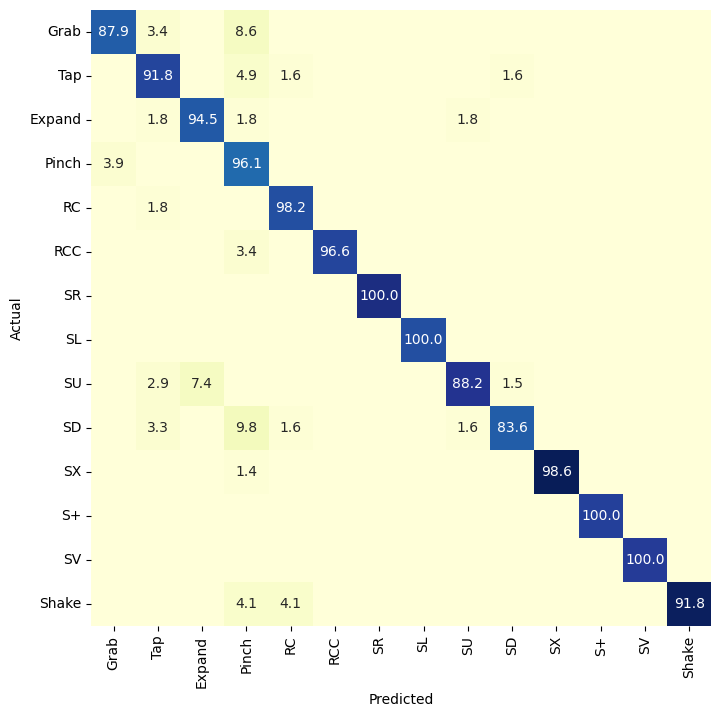

In [23]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_test3.png', labels, ymap=None, figsize=(8,8))

# Policy gradient for frame selection  -------train

In [24]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable  
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


gamma = 0.7


class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(8448,3)) #30 8448
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x): 
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   #
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r     
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class): 
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 5 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = (np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1])) ## -1 is bcz classes are from 1 to 10

  return reward   

def train(oridata,labels): 
    n_states=32 
    n_actions=3 
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num =  10
    max_steps = 32  

    all_rewards = []

    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []

            rng = default_rng()
            Action=[]
            if len(oridata[v])>=32:

                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v]  
            original_fr=XX.clone().detach()  
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 22, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1
                q = np.array(xm1)
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
                M = get_CG(q,C)  
                q = q.reshape(1,32,22,3)
                M = M.reshape(1,32,231)

                original_fr = XX
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1   
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob 
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)
        x_tr = torch.stack(x_tr)
        
        if episode==max_episode_num-1:
          final_ind.append(Action)
            

        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
Train = pickle.load(open(C.data_dir+"train.pkl","rb"))

oridata = []

for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,22,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    
labels = [int(Train['coarse_label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|████████████████████████████████████| 1960/1960 [00:00<00:00, 38522.59it/s]


In [26]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

 10%|███▉                                    | 192/1960 [02:13<20:06,  1.46it/s]


 20%|███████▉                                | 386/1960 [04:26<17:56,  1.46it/s]


 30%|███████████▊                            | 580/1960 [06:41<16:20,  1.41it/s]


 39%|███████████████▊                        | 774/1960 [08:54<13:58,  1.41it/s]


 49%|███████████████████▊                    | 968/1960 [11:08<11:19,  1.46it/s]


 59%|███████████████████████                | 1162/1960 [13:22<09:21,  1.42it/s]


 69%|██████████████████████████▉            | 1356/1960 [15:37<06:55,  1.45it/s]


 79%|██████████████████████████████▊        | 1550/1960 [17:50<04:39,  1.47it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [20:05<02:34,  1.40it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [22:20<00:15,  1.43it/s]


  9%|███▍                                    | 170/1960 [01:57<21:05,  1.41it/s]


 19%|███████▍                                | 364/1960 [04:11<18:21,  1.45it/s]


 28%|███████████▍                            | 558/1960 [06:25<16:39,  1.40it/s]


 38%|███████████████▎                        | 752/1960 [08:39<13:46,  1.46it/s]


 48%|███████████████████▎                    | 946/1960 [10:53<11:41,  1.45it/s]


 58%|██████████████████████▋                | 1140/1960 [13:07<09:17,  1.47it/s]


 68%|██████████████████████████▌            | 1334/1960 [15:21<07:07,  1.46it/s]


 78%|██████████████████████████████▍        | 1528/1960 [17:35<05:01,  1.43it/s]


 88%|██████████████████████████████████▎    | 1722/1960 [19:50<02:42,  1.46it/s]


 98%|██████████████████████████████████████ | 1916/1960 [22:04<00:29,  1.47it/s]


  8%|███                                     | 148/1960 [01:42<21:13,  1.42it/s]


 17%|██████▉                                 | 342/1960 [03:57<18:48,  1.43it/s]


 27%|██████████▉                             | 536/1960 [06:10<16:17,  1.46it/s]


 37%|██████████████▉                         | 730/1960 [08:25<14:24,  1.42it/s]


 47%|██████████████████▊                     | 924/1960 [10:39<11:49,  1.46it/s]


 57%|██████████████████████▏                | 1118/1960 [12:52<09:40,  1.45it/s]


 67%|██████████████████████████             | 1312/1960 [15:07<07:23,  1.46it/s]


 77%|█████████████████████████████▉         | 1506/1960 [17:21<05:10,  1.46it/s]


 87%|█████████████████████████████████▊     | 1700/1960 [19:35<03:03,  1.42it/s]


 97%|█████████████████████████████████████▋ | 1894/1960 [21:50<00:45,  1.45it/s]


  6%|██▌                                     | 126/1960 [01:27<21:09,  1.45it/s]


 16%|██████▌                                 | 320/1960 [03:41<18:37,  1.47it/s]


 26%|██████████▍                             | 514/1960 [05:55<16:41,  1.44it/s]


 36%|██████████████▍                         | 708/1960 [08:09<14:03,  1.48it/s]


 46%|██████████████████▍                     | 902/1960 [10:25<12:24,  1.42it/s]


 56%|█████████████████████▊                 | 1096/1960 [12:38<10:07,  1.42it/s]


 66%|█████████████████████████▋             | 1290/1960 [14:53<07:25,  1.50it/s]


 76%|█████████████████████████████▌         | 1484/1960 [17:07<05:29,  1.44it/s]


 86%|█████████████████████████████████▍     | 1678/1960 [19:21<03:17,  1.43it/s]


 96%|█████████████████████████████████████▏ | 1872/1960 [21:37<01:02,  1.42it/s]


  5%|██                                      | 104/1960 [01:12<21:51,  1.42it/s]


 15%|██████                                  | 298/1960 [03:26<19:41,  1.41it/s]


 25%|██████████                              | 492/1960 [05:40<17:10,  1.42it/s]


 35%|██████████████                          | 686/1960 [07:55<14:39,  1.45it/s]


 45%|█████████████████▉                      | 880/1960 [10:10<12:29,  1.44it/s]


 55%|█████████████████████▎                 | 1074/1960 [12:26<10:07,  1.46it/s]


 65%|█████████████████████████▏             | 1268/1960 [14:40<08:01,  1.44it/s]


 75%|█████████████████████████████          | 1462/1960 [16:55<05:51,  1.42it/s]


 84%|████████████████████████████████▉      | 1656/1960 [19:01<03:25,  1.48it/s]


 94%|████████████████████████████████████▊  | 1850/1960 [21:12<01:14,  1.47it/s]


  4%|█▋                                       | 82/1960 [00:56<22:12,  1.41it/s]


 14%|█████▋                                  | 276/1960 [03:07<18:39,  1.50it/s]


 24%|█████████▌                              | 470/1960 [05:18<16:08,  1.54it/s]


 34%|█████████████▌                          | 664/1960 [07:28<12:57,  1.67it/s]


 44%|█████████████████▌                      | 858/1960 [09:36<12:09,  1.51it/s]


 54%|████████████████████▉                  | 1052/1960 [11:46<10:01,  1.51it/s]


 64%|████████████████████████▊              | 1246/1960 [13:57<08:27,  1.41it/s]


 73%|████████████████████████████▋          | 1440/1960 [16:09<05:48,  1.49it/s]


 83%|████████████████████████████████▌      | 1634/1960 [18:21<03:32,  1.53it/s]


 93%|████████████████████████████████████▎  | 1828/1960 [20:31<01:32,  1.43it/s]


  3%|█▎                                       | 60/1960 [00:41<21:51,  1.45it/s]


 13%|█████▏                                  | 254/1960 [02:54<19:38,  1.45it/s]


 23%|█████████▏                              | 448/1960 [05:04<17:00,  1.48it/s]


 33%|█████████████                           | 642/1960 [07:14<14:40,  1.50it/s]


 43%|█████████████████                       | 836/1960 [09:23<12:41,  1.48it/s]


 53%|████████████████████▍                  | 1030/1960 [11:38<11:50,  1.31it/s]


 62%|████████████████████████▎              | 1224/1960 [13:53<08:25,  1.46it/s]


 72%|████████████████████████████▏          | 1418/1960 [16:07<06:13,  1.45it/s]


 82%|████████████████████████████████       | 1612/1960 [18:17<03:54,  1.49it/s]


 92%|███████████████████████████████████▉   | 1806/1960 [20:27<01:46,  1.45it/s]


  2%|▊                                        | 38/1960 [00:25<21:21,  1.50it/s]


 12%|████▋                                   | 232/1960 [02:46<21:19,  1.35it/s]


 22%|████████▋                               | 426/1960 [04:56<18:14,  1.40it/s]


 32%|████████████▋                           | 620/1960 [07:08<15:20,  1.46it/s]


 42%|████████████████▌                       | 814/1960 [09:19<13:16,  1.44it/s]


 51%|████████████████████                   | 1008/1960 [11:35<10:30,  1.51it/s]


 61%|███████████████████████▉               | 1202/1960 [13:47<08:21,  1.51it/s]


 71%|███████████████████████████▊           | 1396/1960 [15:58<06:19,  1.48it/s]


 81%|███████████████████████████████▋       | 1590/1960 [18:07<04:00,  1.54it/s]


 91%|███████████████████████████████████▍   | 1784/1960 [20:17<01:55,  1.52it/s]


  1%|▎                                        | 16/1960 [00:10<22:16,  1.45it/s]


 11%|████▎                                   | 210/1960 [02:20<20:06,  1.45it/s]


 21%|████████▏                               | 404/1960 [04:30<17:15,  1.50it/s]


 31%|████████████▏                           | 598/1960 [06:42<15:05,  1.50it/s]


 40%|████████████████▏                       | 792/1960 [08:55<13:04,  1.49it/s]


 50%|████████████████████                    | 986/1960 [11:18<11:55,  1.36it/s]


 60%|███████████████████████▍               | 1180/1960 [13:39<08:38,  1.50it/s]


 70%|███████████████████████████▎           | 1374/1960 [16:03<06:45,  1.44it/s]


 80%|███████████████████████████████▏       | 1568/1960 [18:13<04:24,  1.48it/s]


 90%|███████████████████████████████████    | 1762/1960 [20:22<02:11,  1.50it/s]


100%|██████████████████████████████████████▉| 1956/1960 [22:33<00:02,  1.47it/s]


 10%|███▊                                    | 188/1960 [02:07<19:57,  1.48it/s]


 19%|███████▊                                | 382/1960 [04:19<17:49,  1.48it/s]


 29%|███████████▊                            | 576/1960 [06:28<15:10,  1.52it/s]


 39%|███████████████▋                        | 770/1960 [08:41<13:16,  1.49it/s]


 49%|███████████████████▋                    | 964/1960 [10:51<10:57,  1.52it/s]


 59%|███████████████████████                | 1158/1960 [13:05<09:44,  1.37it/s]


 69%|██████████████████████████▉            | 1352/1960 [15:18<06:52,  1.47it/s]


 79%|██████████████████████████████▊        | 1546/1960 [17:29<04:37,  1.49it/s]


 89%|██████████████████████████████████▌    | 1740/1960 [19:38<02:26,  1.50it/s]


 99%|██████████████████████████████████████▍| 1934/1960 [21:52<00:16,  1.53it/s]


100%|███████████████████████████████████████| 10/10 [3:44:03<00:00, 1344.33s/it]


In [27]:
# torch.save(policy_net.state_dict(),"model/policy_net.pth")

[-66.34375, -80.34375, -74.3125, -61.84375, -54.53125, -61.8125, -54.46875, -56.15625, -57.84375, -57.875]


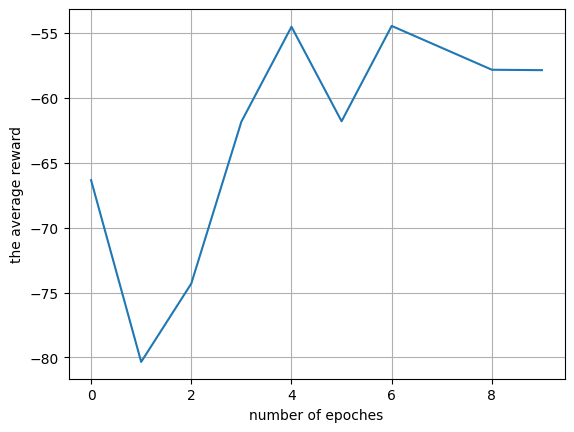

In [28]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("//data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/SHREC/images/DRLDDNet_14_reward.png")
plt.grid()

In [29]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|██████████████████████████████████████| 1960/1960 [00:14<00:00, 131.60it/s]


In [30]:
# it may takes several times to reach the reported performance

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/700
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0739 - accuracy: 0.9827 - val_loss: 0.3034 - val_accuracy: 0.9167
Epoch 2/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.1545 - accuracy: 0.9602 - val_loss: 0.3225 - val_accuracy: 0.9083
Epoch 3/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.1338 - accuracy: 0.9638 - val_loss: 0.3038 - val_accuracy: 0.9143
Epoch 4/700
1960/1960 [==============================] - 0s 132us/step - loss: 0.0964 - accuracy: 0.9776 - val_loss: 0.3152 - val_accuracy: 0.9202
Epoch 5/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0915 - accuracy: 0.9801 - val_loss: 0.3343 - val_accuracy: 0.9202
Epoch 6/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0917 - accuracy: 0.9781 - val_loss: 0.3458 - val_accuracy: 0.9060
Epoch 7/700
1960/1960 [==============================] - 0s 127us/step - 

Epoch 57/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0232 - accuracy: 0.9974 - val_loss: 0.2114 - val_accuracy: 0.9488
Epoch 58/700
1960/1960 [==============================] - 0s 132us/step - loss: 0.0222 - accuracy: 0.9974 - val_loss: 0.2102 - val_accuracy: 0.9488
Epoch 59/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0205 - accuracy: 0.9995 - val_loss: 0.2090 - val_accuracy: 0.9488
Epoch 60/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0247 - accuracy: 0.9980 - val_loss: 0.2084 - val_accuracy: 0.9500
Epoch 61/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0267 - accuracy: 0.9974 - val_loss: 0.2078 - val_accuracy: 0.9524
Epoch 62/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0237 - accuracy: 0.9974 - val_loss: 0.2073 - val_accuracy: 0.9500
Epoch 63/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0268 - accuracy: 0.9964 - val_

Epoch 113/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0201 - accuracy: 0.9980 - val_loss: 0.1798 - val_accuracy: 0.9595
Epoch 114/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0236 - accuracy: 0.9980 - val_loss: 0.1796 - val_accuracy: 0.9595
Epoch 115/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0212 - accuracy: 0.9980 - val_loss: 0.1794 - val_accuracy: 0.9595
Epoch 116/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0210 - accuracy: 0.9995 - val_loss: 0.1792 - val_accuracy: 0.9595
Epoch 117/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0207 - accuracy: 0.9985 - val_loss: 0.1791 - val_accuracy: 0.9595
Epoch 118/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0252 - accuracy: 0.9974 - val_loss: 0.1789 - val_accuracy: 0.9595
Epoch 119/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0164 - accuracy: 0.9995

Epoch 168/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0212 - accuracy: 0.9980 - val_loss: 0.1741 - val_accuracy: 0.9619
Epoch 169/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0197 - accuracy: 0.9985 - val_loss: 0.1741 - val_accuracy: 0.9619
Epoch 170/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0198 - accuracy: 0.9974 - val_loss: 0.1741 - val_accuracy: 0.9619
Epoch 171/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0197 - accuracy: 0.9980 - val_loss: 0.1740 - val_accuracy: 0.9619
Epoch 172/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0172 - accuracy: 0.9995 - val_loss: 0.1740 - val_accuracy: 0.9619
Epoch 173/700
1960/1960 [==============================] - 0s 145us/step - loss: 0.0194 - accuracy: 0.9990 - val_loss: 0.1740 - val_accuracy: 0.9619
Epoch 174/700
1960/1960 [==============================] - 0s 145us/step - loss: 0.0224 - accuracy: 0.9974

Epoch 223/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0205 - accuracy: 0.9990 - val_loss: 0.1743 - val_accuracy: 0.9583
Epoch 224/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0178 - accuracy: 0.9995 - val_loss: 0.1743 - val_accuracy: 0.9583
Epoch 225/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0202 - accuracy: 0.9980 - val_loss: 0.1742 - val_accuracy: 0.9583
Epoch 226/700
1960/1960 [==============================] - 0s 145us/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.1743 - val_accuracy: 0.9583
Epoch 227/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0240 - accuracy: 0.9974 - val_loss: 0.1743 - val_accuracy: 0.9583
Epoch 228/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0185 - accuracy: 0.9985 - val_loss: 0.1743 - val_accuracy: 0.9583
Epoch 229/700
1960/1960 [==============================] - 0s 143us/step - loss: 0.0224 - accuracy: 0.9964

Epoch 278/700
1960/1960 [==============================] - 0s 147us/step - loss: 0.0172 - accuracy: 0.9990 - val_loss: 0.1758 - val_accuracy: 0.9560
Epoch 279/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0208 - accuracy: 0.9974 - val_loss: 0.1759 - val_accuracy: 0.9560
Epoch 280/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0204 - accuracy: 0.9995 - val_loss: 0.1759 - val_accuracy: 0.9560
Epoch 281/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0190 - accuracy: 0.9974 - val_loss: 0.1760 - val_accuracy: 0.9560
Epoch 282/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0201 - accuracy: 0.9985 - val_loss: 0.1761 - val_accuracy: 0.9560
Epoch 283/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0211 - accuracy: 0.9990 - val_loss: 0.1761 - val_accuracy: 0.9548
Epoch 284/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0215 - accuracy: 0.9974

Epoch 333/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0222 - accuracy: 0.9969 - val_loss: 0.1757 - val_accuracy: 0.9560
Epoch 334/700
1960/1960 [==============================] - 0s 147us/step - loss: 0.0215 - accuracy: 0.9969 - val_loss: 0.1757 - val_accuracy: 0.9560
Epoch 335/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0225 - accuracy: 0.9974 - val_loss: 0.1758 - val_accuracy: 0.9560
Epoch 336/700
1960/1960 [==============================] - 0s 132us/step - loss: 0.0208 - accuracy: 0.9969 - val_loss: 0.1758 - val_accuracy: 0.9560
Epoch 337/700
1960/1960 [==============================] - 0s 142us/step - loss: 0.0212 - accuracy: 0.9974 - val_loss: 0.1759 - val_accuracy: 0.9560
Epoch 338/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0184 - accuracy: 0.9980 - val_loss: 0.1759 - val_accuracy: 0.9560
Epoch 339/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0264 - accuracy: 0.9974

Epoch 388/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0186 - accuracy: 0.9980 - val_loss: 0.1769 - val_accuracy: 0.9560
Epoch 389/700
1960/1960 [==============================] - 0s 126us/step - loss: 0.0226 - accuracy: 0.9974 - val_loss: 0.1769 - val_accuracy: 0.9560
Epoch 390/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0172 - accuracy: 0.9995 - val_loss: 0.1768 - val_accuracy: 0.9560
Epoch 391/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0224 - accuracy: 0.9974 - val_loss: 0.1767 - val_accuracy: 0.9560
Epoch 392/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0204 - accuracy: 0.9974 - val_loss: 0.1767 - val_accuracy: 0.9560
Epoch 393/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.0255 - accuracy: 0.9964 - val_loss: 0.1767 - val_accuracy: 0.9560
Epoch 394/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0179 - accuracy: 0.9985

Epoch 443/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0219 - accuracy: 0.9974 - val_loss: 0.1778 - val_accuracy: 0.9595
Epoch 444/700
1960/1960 [==============================] - 0s 126us/step - loss: 0.0183 - accuracy: 0.9990 - val_loss: 0.1778 - val_accuracy: 0.9595
Epoch 445/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0189 - accuracy: 0.9980 - val_loss: 0.1778 - val_accuracy: 0.9595
Epoch 446/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0196 - accuracy: 0.9964 - val_loss: 0.1778 - val_accuracy: 0.9583
Epoch 447/700
1960/1960 [==============================] - 0s 126us/step - loss: 0.0209 - accuracy: 0.9990 - val_loss: 0.1777 - val_accuracy: 0.9583
Epoch 448/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0171 - accuracy: 0.9990 - val_loss: 0.1777 - val_accuracy: 0.9583
Epoch 449/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0181 - accuracy: 0.9995

Epoch 498/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0218 - accuracy: 0.9974 - val_loss: 0.1787 - val_accuracy: 0.9560
Epoch 499/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0186 - accuracy: 0.9985 - val_loss: 0.1787 - val_accuracy: 0.9560
Epoch 500/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0199 - accuracy: 0.9980 - val_loss: 0.1787 - val_accuracy: 0.9560
Epoch 501/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0229 - accuracy: 0.9990 - val_loss: 0.1788 - val_accuracy: 0.9560
Epoch 502/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0182 - accuracy: 0.9995 - val_loss: 0.1788 - val_accuracy: 0.9560
Epoch 503/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0209 - accuracy: 0.9980 - val_loss: 0.1788 - val_accuracy: 0.9560
Epoch 504/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0200 - accuracy: 0.9980

Epoch 553/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0195 - accuracy: 0.9985 - val_loss: 0.1803 - val_accuracy: 0.9560
Epoch 554/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0211 - accuracy: 0.9985 - val_loss: 0.1803 - val_accuracy: 0.9560
Epoch 555/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0190 - accuracy: 0.9985 - val_loss: 0.1803 - val_accuracy: 0.9560
Epoch 556/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0188 - accuracy: 0.9995 - val_loss: 0.1804 - val_accuracy: 0.9560
Epoch 557/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0170 - accuracy: 0.9985 - val_loss: 0.1805 - val_accuracy: 0.9560
Epoch 558/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0192 - accuracy: 0.9985 - val_loss: 0.1806 - val_accuracy: 0.9560
Epoch 559/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0193 - accuracy: 0.9990

Epoch 608/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0211 - accuracy: 0.9969 - val_loss: 0.1804 - val_accuracy: 0.9560
Epoch 609/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0206 - accuracy: 0.9974 - val_loss: 0.1803 - val_accuracy: 0.9560
Epoch 610/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0173 - accuracy: 0.9990 - val_loss: 0.1803 - val_accuracy: 0.9560
Epoch 611/700
1960/1960 [==============================] - 0s 132us/step - loss: 0.0186 - accuracy: 0.9995 - val_loss: 0.1803 - val_accuracy: 0.9560
Epoch 612/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0203 - accuracy: 0.9964 - val_loss: 0.1803 - val_accuracy: 0.9560
Epoch 613/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0159 - accuracy: 0.9990 - val_loss: 0.1802 - val_accuracy: 0.9560
Epoch 614/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0180 - accuracy: 0.9985

Epoch 663/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0197 - accuracy: 0.9974 - val_loss: 0.1797 - val_accuracy: 0.9595
Epoch 664/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0174 - accuracy: 0.9974 - val_loss: 0.1797 - val_accuracy: 0.9595
Epoch 665/700
1960/1960 [==============================] - 0s 132us/step - loss: 0.0192 - accuracy: 0.9964 - val_loss: 0.1797 - val_accuracy: 0.9595
Epoch 666/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0173 - accuracy: 0.9985 - val_loss: 0.1798 - val_accuracy: 0.9595
Epoch 667/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0175 - accuracy: 0.9974 - val_loss: 0.1798 - val_accuracy: 0.9595
Epoch 668/700
1960/1960 [==============================] - 0s 148us/step - loss: 0.0174 - accuracy: 0.9990 - val_loss: 0.1798 - val_accuracy: 0.9595
Epoch 669/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0172 - accuracy: 0.9980

In [31]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [32]:
labels_train = ['Grab', 'Tap','Expand','Pinch', 'RC', 'RCC','SR', 'SL', 'SU', 'SD','SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels_train[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels_train[i])

In [33]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9595238095238096


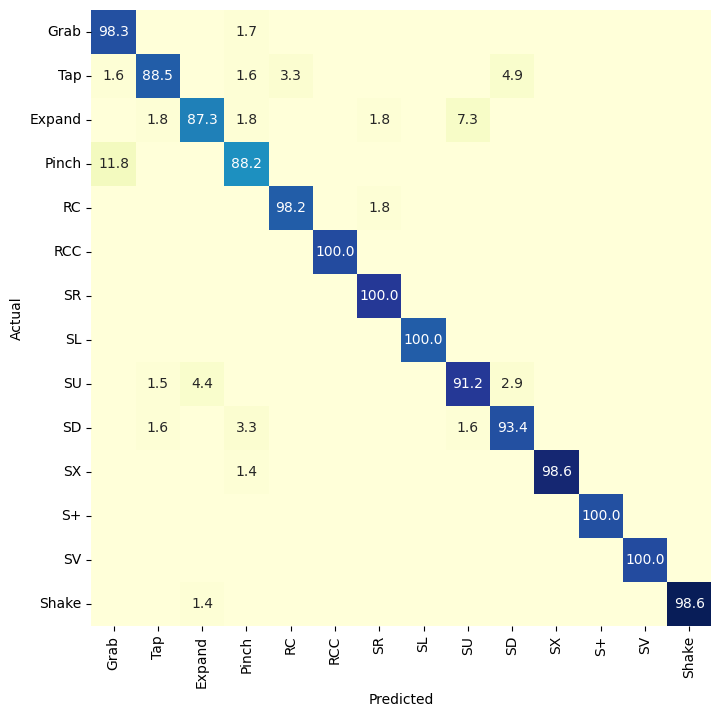

In [34]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_test4.png', labels_train, ymap=None, figsize=(8,8))

### epoch 2 

In [ ]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

In [ ]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_14_reward.png")
plt.grid()

In [ ]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

In [ ]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_5.png', labels, ymap=None, figsize=(18,18))

### epoch 3 

In [ ]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

### epoch 4

In [ ]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

### epoch 5 

In [ ]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))